# Vacunas

In [2]:
pip install pandas==2.2.0

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 11.6/11.6 MB 5.7 MB/s eta 0:00:00
     ---------------------------------------- 15.8/15.8 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\HP\\AppData\\Roaming\\Python\\Python39\\site-packages\\~umpy.libs\\libscipy_openblas64_-caad452230ae4ddb57899b8b3a33c55c.dll'
Check the permissions.



In [1]:
from sodapy import Socrata
import pandas as pd

# Conectar al portal de datos del CDC
client = Socrata("data.cdc.gov", None)

# Consultar solo los registros de diciembre de 2021
# Formato de fecha esperado: YYYY-MM-DDTHH:MM:SS (ISO8601)
results = client.get(
    "8xkx-amqh",
    where="date between '2021-05-01T00:00:00' and '2021-05-31T23:59:59'",
    limit=10000  # Puedes ajustar el límite según sea necesario
)

# Convertir a DataFrame
vacunas = pd.DataFrame.from_records(results)

# Mostrar los primeros registros
print(vacunas.head())

                      date   fips mmwr_week       recip_county recip_state  \
0  2021-05-01T00:00:00.000  37059        17       Davie County          NC   
1  2021-05-01T00:00:00.000  17189        17  Washington County          IL   
2  2021-05-01T00:00:00.000  06029        17        Kern County          CA   
3  2021-05-01T00:00:00.000  51580        17     Covington city          VA   
4  2021-05-01T00:00:00.000  36111        17      Ulster County          NY   

  completeness_pct administered_dose1_recip administered_dose1_pop_pct  \
0             96.4                    17006                       39.7   
1             97.6                     5728                       41.2   
2             96.9                   276004                       30.7   
3                0                        0                          0   
4             97.2                    89312                       50.3   

  administered_dose1_recip_12plus administered_dose1_recip_12pluspop_pct  ...  \
0    

In [5]:
df_unico_fips = vacunas.drop_duplicates(subset='fips', keep='first')

NameError: name 'vacunas' is not defined

In [6]:
df_stata2021 = pd.merge(df_merged, df_unico_fips, on='fips', how='inner')
df_stata2021.to_stata('baselimpiavac2021.dta', write_index=False)
df_stata2021

NameError: name 'pd' is not defined

# Votaciones

In [2]:
# connect to data
import requests
import pandas as pd
election_url = "https://static01.nyt.com/elections-assets/2020/data/api/2020-11-03/national-map-page/national/president.json"

# make an http request for the page
election_request = requests.request(
    method='GET', 
    url=election_url,
    headers={ "Accept": "application/json" }
)

election_response = election_request.json()

election_data = election_response['data']['races']

## parse response into dataframe, and select and rename final columns
election_data_df = pd.DataFrame(election_data)[['state_name', 'counties']].rename(columns={"state_name": "t_state_name"})

# after https://stackoverflow.com/a/49962887
# unnest 'counties' column, turning object keys in dataframe columns and object values into rows, select certain keys from each array, and rename those keys (columns)
election_data_df = pd.DataFrame(
    [
        dict(y, t_state_name=i) for i, x in zip(
            election_data_df['t_state_name'],
            election_data_df['counties']
        ) for y in x
    ]
)[['fips', 'name', 'votes', 't_state_name', 'results']].rename(columns={"fips": "geoid", "votes": "total_votes", "name": "t_county_name"})

# after https://stackoverflow.com/a/38231651
## unravel dictionary (JSON object) into other columns, choose final columns, rename them, and cast their data types
election_data_df = pd.concat(
    [
        election_data_df.drop(['results'], axis=1), 
        election_data_df['results'].apply(pd.Series)
    ], 
    axis=1
)[['geoid', 't_county_name', 'total_votes', 't_state_name', 'trumpd', 'bidenj']].rename(columns={"trumpd": "votes_gop", "bidenj": "votes_dem"}).astype({'votes_gop': 'int64', 'votes_dem': 'int64'})

# create state FIPS codes from the 5-digit 'geoid'
election_data_df['fips'] = election_data_df['geoid']

election_data_df['dem_won'] = (election_data_df['votes_dem'] > election_data_df['votes_gop']).astype(int)
election_data_df['margin_votes'] = (election_data_df['votes_dem'] - election_data_df['votes_gop'])*100
election_data_df['margin_pct'] = (election_data_df['votes_dem'] - election_data_df['votes_gop'])*100 / (election_data_df['total_votes'])


# Merge

In [3]:
df_stata = pd.merge(election_data_df, df_unico_fips, on='fips', how='inner')
df_stata 

NameError: name 'pd' is not defined

In [10]:
# Columnas que no queremos procesar
excluir = ['date', 'fips', 'mmwr_week', 'recip_county', 'recip_state', 'dem_won']

# Seleccionamos columnas que terminan en 'pct' y no están en la lista de exclusión
columnas_pct = [col for col in df_stata.columns if col.endswith('pct') and col not in excluir]

# Convertimos esas columnas a numéricas, forzando donde sea necesario
df_stata[columnas_pct] = df_stata[columnas_pct].apply(pd.to_numeric, errors='coerce')


# Calculamos los promedios por grupo
promedios = df_stata.groupby('dem_won')[columnas_pct].mean()

# Calculamos la diferencia: promedio(dem_won=1) - promedio(dem_won=0)
diferencia = promedios.loc[1] - promedios.loc[0]

# Mostramos resultados ordenados por magnitud de la diferencia
diferencia = diferencia.sort_values(ascending=False)

print(diferencia)

administered_dose1_recip_18pluspop_pct    9.906614
administered_dose1_recip_12pluspop_pct    9.489005
administered_dose1_pop_pct                8.790227
administered_dose1_recip_65pluspop_pct    8.000221
series_complete_18pluspop_pct             4.810403
series_complete_65pluspop_pct             4.716257
series_complete_12pluspop_pct             4.588825
series_complete_pop_pct                   4.061096
completeness_pct                          1.435155
margin_pct                                0.663444
dtype: float64


In [11]:
import scipy.stats as stats

resultados = []

for col in columnas_pct:
    grupo0 = df_stata.loc[df_stata['dem_won'] == 0, col].dropna()
    grupo1 = df_stata.loc[df_stata['dem_won'] == 1, col].dropna()
    
    # Test t para muestras independientes
    t_stat, p_val = stats.ttest_ind(grupo1, grupo0, equal_var=False)  # Welch's t-test
    
    diff = grupo1.mean() - grupo0.mean()
    signif = "Sí" if p_val < 0.05 else "No"
    
    resultados.append((col, diff, p_val, signif))

# Ordenar por magnitud absoluta de la diferencia
resultados = sorted(resultados, key=lambda x: abs(x[1]), reverse=True)

# Mostrar resultados
print(f"{'Variable':<20} {'Diferencia':>10} {'p-valor':>10} {'Significativa':>15}")
for var, diff, p_val, signif in resultados:
    print(f"{var:<20} {diff:10.4f} {p_val:10.4f} {signif:>15}")


Variable             Diferencia    p-valor   Significativa
administered_dose1_recip_18pluspop_pct     9.9066     0.0000              Sí
administered_dose1_recip_12pluspop_pct     9.4890     0.0000              Sí
administered_dose1_pop_pct     8.7902     0.0000              Sí
administered_dose1_recip_65pluspop_pct     8.0002     0.0000              Sí
series_complete_18pluspop_pct     4.8104     0.0000              Sí
series_complete_65pluspop_pct     4.7163     0.0002              Sí
series_complete_12pluspop_pct     4.5888     0.0000              Sí
series_complete_pop_pct     4.0611     0.0000              Sí
completeness_pct         1.4352     0.2460              No
margin_pct               0.6634     0.0000              Sí


In [12]:
import scipy.stats as stats

# Filtramos el DataFrame según el margen
df_filtrado = df_stata[(df_stata['margin_pct'] >= -5) & (df_stata['margin_pct'] <= 10)]

resultados = []

for col in columnas_pct:
    grupo0 = df_filtrado.loc[df_filtrado['dem_won'] == 0, col].dropna()
    grupo1 = df_filtrado.loc[df_filtrado['dem_won'] == 1, col].dropna()
    
    # Test t para muestras independientes (Welch)
    t_stat, p_val = stats.ttest_ind(grupo1, grupo0, equal_var=False)
    
    diff = grupo1.mean() - grupo0.mean()
    signif = "Sí" if p_val < 0.05 else "No"
    
    resultados.append((col, diff, p_val, signif))

# Ordenar por magnitud absoluta de la diferencia
resultados = sorted(resultados, key=lambda x: abs(x[1]), reverse=True)

# Mostrar resultados
print(f"{'Variable':<20} {'Diferencia':>10} {'p-valor':>10} {'Significativa':>15}")
for var, diff, p_val, signif in resultados:
    print(f"{var:<20} {diff:10.4f} {p_val:10.4f} {signif:>15}")

Variable             Diferencia    p-valor   Significativa
administered_dose1_recip_18pluspop_pct     9.9066     0.0000              Sí
administered_dose1_recip_12pluspop_pct     9.4890     0.0000              Sí
administered_dose1_pop_pct     8.7902     0.0000              Sí
administered_dose1_recip_65pluspop_pct     8.0002     0.0000              Sí
series_complete_18pluspop_pct     4.8104     0.0000              Sí
series_complete_65pluspop_pct     4.7163     0.0002              Sí
series_complete_12pluspop_pct     4.5888     0.0000              Sí
series_complete_pop_pct     4.0611     0.0000              Sí
completeness_pct         1.4352     0.2460              No
margin_pct               0.6634     0.0000              Sí


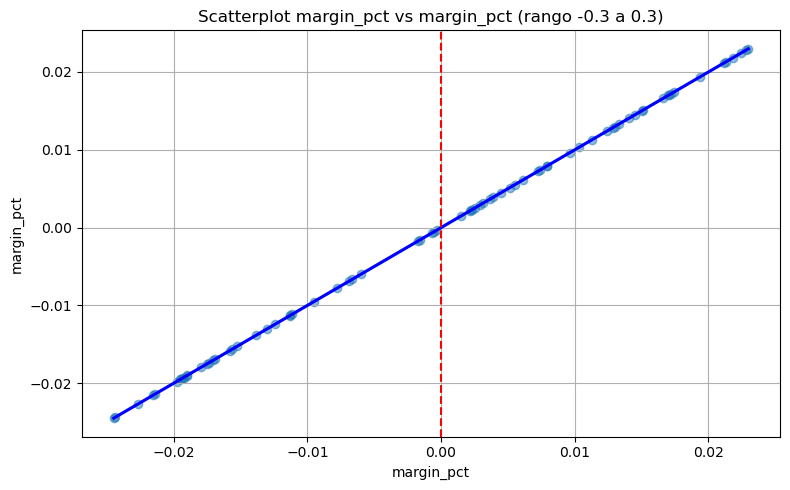

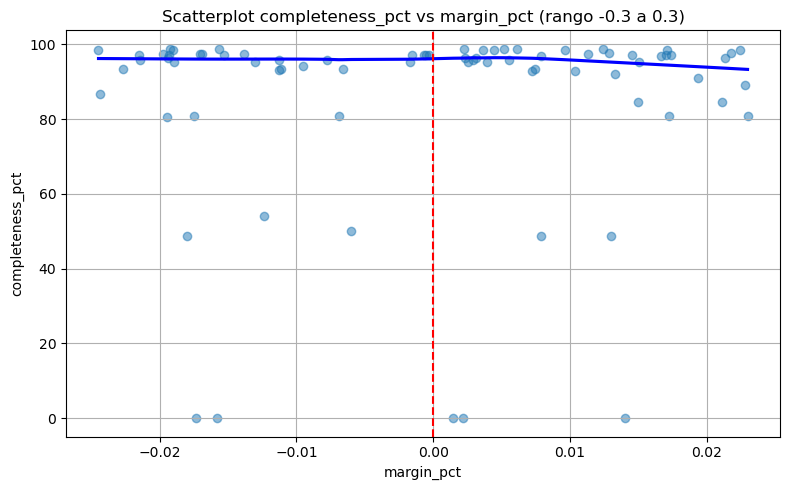

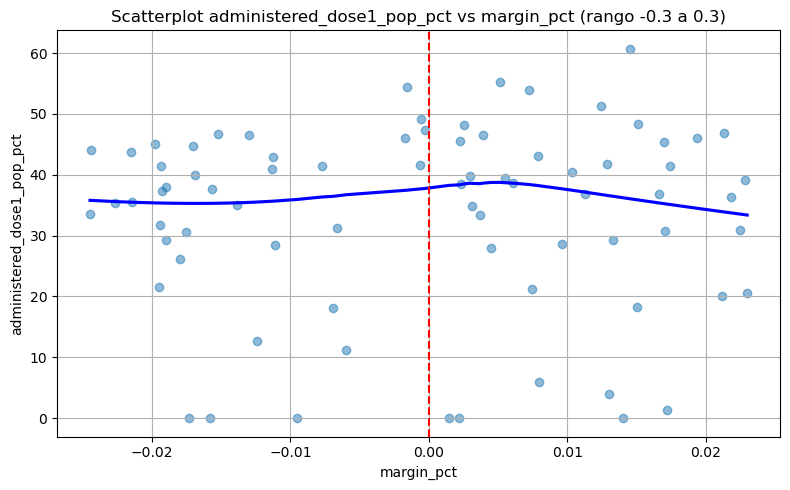

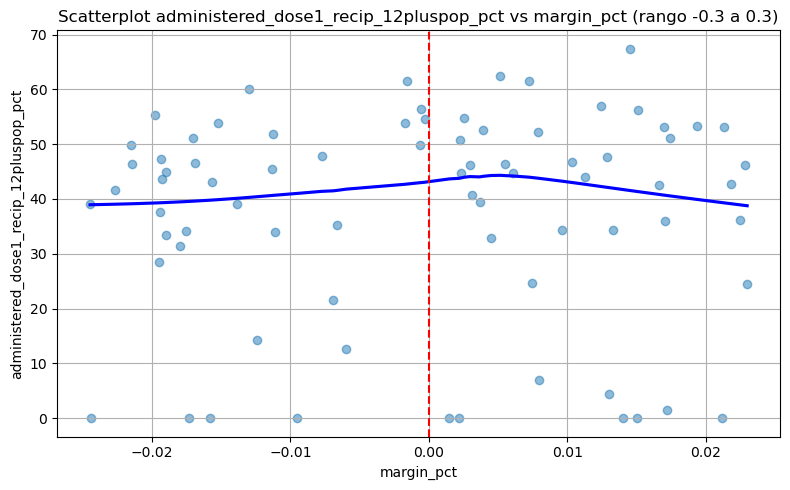

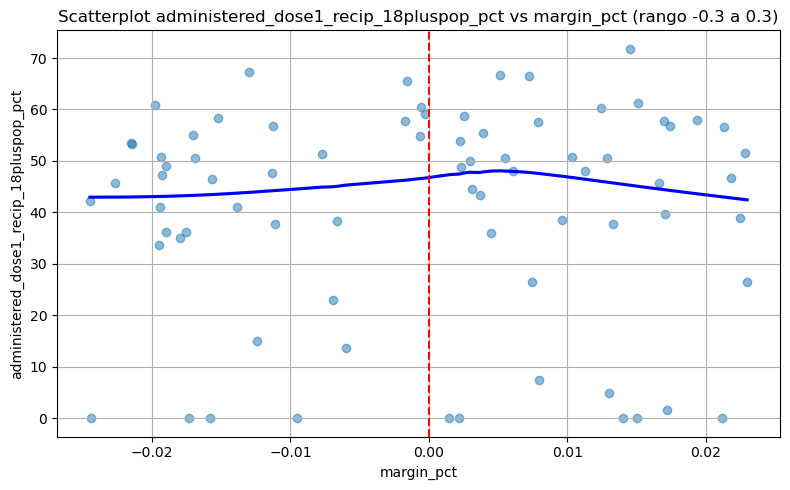

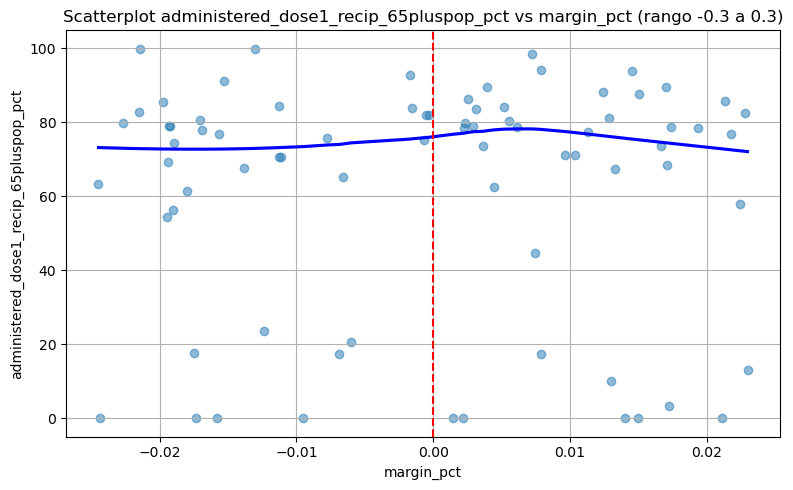

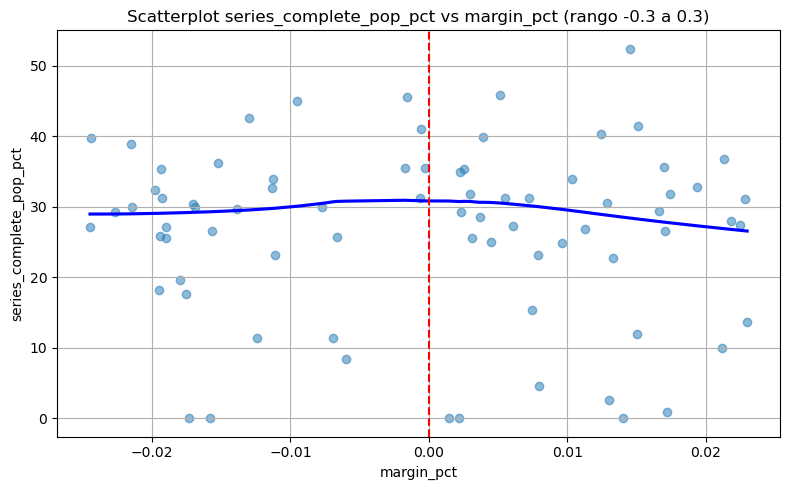

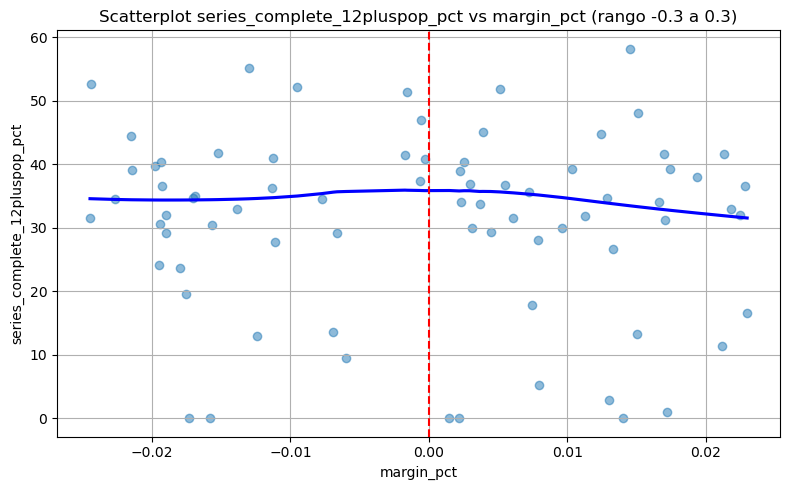

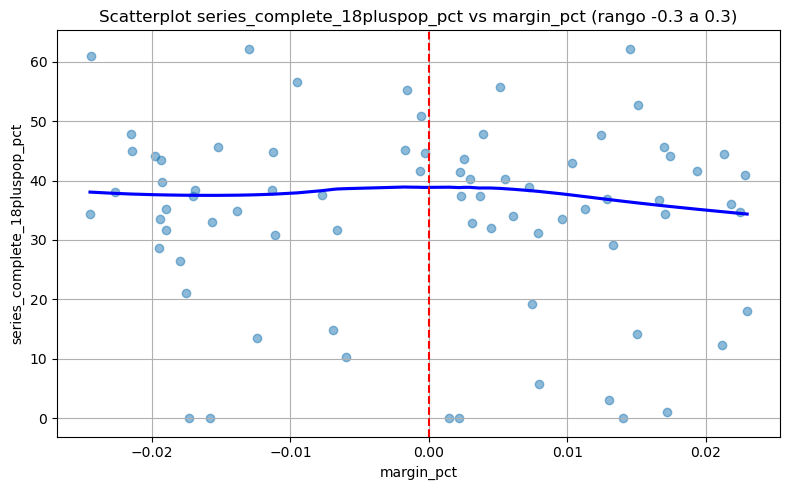

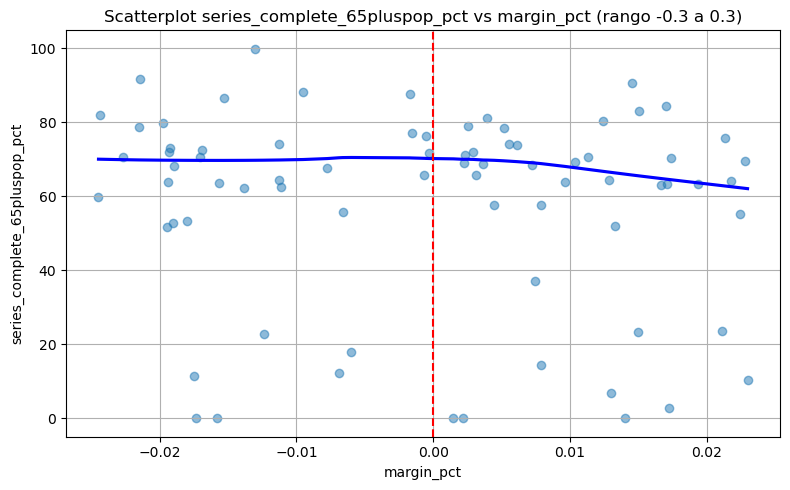

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


# Graficar cada variable que termina en _pct, filtrando el rango de margin_pct
for col in columnas_pct:
    # Filtrar a los valores entre -0.3 y 0.3
    df_subset = df_stata[(df_stata['margin_pct'] >= -0.025) & (df_stata['margin_pct'] <= 0.025)]

    plt.figure(figsize=(8, 5))
    
    # Scatterplot con suavizado lowess
    sns.regplot(
        x='margin_pct',
        y=col,
        data=df_subset,
        lowess=True,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'blue'}
    )
    
    # Línea vertical en 0
    plt.axvline(0, color='red', linestyle='--')
    
    # Títulos y etiquetas
    plt.title(f'Scatterplot {col} vs margin_pct (rango -0.3 a 0.3)')
    plt.xlabel('margin_pct')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

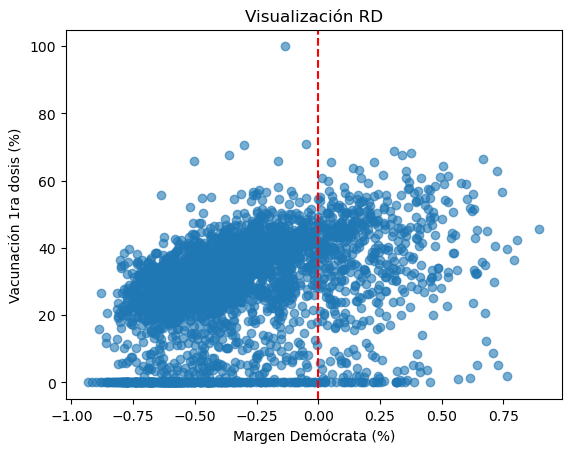

In [14]:
import matplotlib.pyplot as plt

plt.scatter(df_stata["margin_pct"], df_stata["administered_dose1_pop_pct"], alpha=0.6)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Margen Demócrata (%)")
plt.ylabel("Vacunación 1ra dosis (%)")
plt.title("Visualización RD")
plt.show()

In [16]:

import statsmodels.formula.api as smf
# Crear X^2 y las interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.24 a 0.24
df1 = df_stata[df_stata["margin_pct"].between(-0.025, 0.025)]

# Regresión (asegúrate que 'vacunacion' sea el nombre correcto de la variable dependiente)
model1 = smf.ols("administered_dose1_pop_pct  ~ dem_won + margin_pct", data=df1).fit(cov_type='HC1')
print(model1.summary())

                                OLS Regression Results                                
Dep. Variable:     administered_dose1_pop_pct   R-squared:                       0.002
Model:                                    OLS   Adj. R-squared:                 -0.025
Method:                         Least Squares   F-statistic:                   0.09133
Date:                        Tue, 27 May 2025   Prob (F-statistic):              0.913
Time:                                19:55:42   Log-Likelihood:                -314.62
No. Observations:                          76   AIC:                             635.2
Df Residuals:                              73   BIC:                             642.2
Df Model:                                   2                                         
Covariance Type:                          HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

In [17]:

import statsmodels.formula.api as smf
# Crear X^2 y las interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.24 a 0.24
df1 = df_stata[df_stata["margin_pct"].between(-0.05, 0.05)]

# Regresión (asegúrate que 'vacunacion' sea el nombre correcto de la variable dependiente)
model1 = smf.ols("administered_dose1_pop_pct  ~ dem_won + margin_pct", data=df1).fit(cov_type='HC1')
print(model1.summary())

                                OLS Regression Results                                
Dep. Variable:     administered_dose1_pop_pct   R-squared:                       0.001
Model:                                    OLS   Adj. R-squared:                 -0.012
Method:                         Least Squares   F-statistic:                   0.09789
Date:                        Tue, 27 May 2025   Prob (F-statistic):              0.907
Time:                                19:56:08   Log-Likelihood:                -655.05
No. Observations:                         158   AIC:                             1316.
Df Residuals:                             155   BIC:                             1325.
Df Model:                                   2                                         
Covariance Type:                          HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

In [23]:

import statsmodels.formula.api as smf
# Crear X^2 y las interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.24 a 0.24
df1 = df_stata[df_stata["margin_pct"].between(-0.075, 0.075)]

# Regresión (asegúrate que 'vacunacion' sea el nombre correcto de la variable dependiente)
model1 = smf.ols("administered_dose1_recip_65pluspop_pct  ~ dem_won + margin_pct +T_X", data=df1).fit(cov_type='HC1')
print(model1.summary())

                                      OLS Regression Results                                      
Dep. Variable:     administered_dose1_recip_65pluspop_pct   R-squared:                       0.001
Model:                                                OLS   Adj. R-squared:                 -0.012
Method:                                     Least Squares   F-statistic:                   0.05913
Date:                                    Tue, 27 May 2025   Prob (F-statistic):              0.981
Time:                                            19:59:10   Log-Likelihood:                -1117.6
No. Observations:                                     232   AIC:                             2243.
Df Residuals:                                         228   BIC:                             2257.
Df Model:                                               3                                         
Covariance Type:                                      HC1                                         
          

In [25]:

import statsmodels.formula.api as smf
# Crear X^2 y las interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.24 a 0.24
df1 = df_stata[df_stata["margin_pct"].between(-0.025, 0.025)]

# Regresión (asegúrate que 'vacunacion' sea el nombre correcto de la variable dependiente)
model1 = smf.ols("administered_dose1_recip_65pluspop_pct  ~ dem_won + margin_pct +T_X", data=df1).fit(cov_type='HC1')
print(model1.summary())

                                      OLS Regression Results                                      
Dep. Variable:     administered_dose1_recip_65pluspop_pct   R-squared:                       0.011
Model:                                                OLS   Adj. R-squared:                 -0.030
Method:                                     Least Squares   F-statistic:                    0.2646
Date:                                    Tue, 27 May 2025   Prob (F-statistic):              0.851
Time:                                            19:59:43   Log-Likelihood:                -369.30
No. Observations:                                      76   AIC:                             746.6
Df Residuals:                                          72   BIC:                             755.9
Df Model:                                               3                                         
Covariance Type:                                      HC1                                         
          

# Repetir con los que mantienen votacion de 2016, definitivamente mas sentido**

In [3]:
election_data_df2016 = pd.read_csv("results2016.csv")
election_data_df2016['dem_won2016'] = (election_data_df['votes_dem'] > election_data_df['votes_gop']).astype(int)
election_data_df2016['margin_votes'] =( election_data_df2016['votes_dem'] - election_data_df2016['votes_gop'])*100
election_data_df2016['margin_pct'] = (election_data_df2016['votes_dem'] - election_data_df2016['votes_gop']) *100 / (election_data_df2016['total_votes'])
election_data_df2016

Unnamed: 0  votes_dem  votes_gop  total_votes   per_dem   per_gop  \
0              0    93003.0   130413.0     246588.0  0.377159  0.528870   
1              1    93003.0   130413.0     246588.0  0.377159  0.528870   
2              2    93003.0   130413.0     246588.0  0.377159  0.528870   
3              3    93003.0   130413.0     246588.0  0.377159  0.528870   
4              4    93003.0   130413.0     246588.0  0.377159  0.528870   
...          ...        ...        ...          ...       ...       ...   
3136        3136     3233.0    12153.0      16661.0  0.194046  0.729428   
3137        3137     7313.0     3920.0      12176.0  0.600608  0.321945   
3138        3138     1202.0     6154.0       8053.0  0.149261  0.764187   
3139        3139      532.0     2911.0       3715.0  0.143203  0.783580   
3140        3140      294.0     2898.0       3334.0  0.088182  0.869226   

        diff per_point_diff state_abbr        county_name  combined_fips  \
0     37,410         15.17%         AK             Alaska           2013   
1     37,410         15.17%         AK             Alaska           2016   
2     37,410         15.17%         AK             Alaska           2020   
3     37,410         15.17%         AK             Alaska           2050   
4     37,410         15.17%         AK             Alaska           2060   
...      ...            ...        ...                ...            ...   
3136   8,920         53.54%         WY  Sweetwater County          56037   
3137   3,393         27.87%         WY       Teton County          56039   
3138   4,952         61.49%         WY       Uinta County          56041   
3139   2,379         64.04%         WY    Washakie County          56043   
3140   2,604         78.10%         WY      Weston County          56045   

      dem_won2016  margin_votes  margin_pct  
0               0    -3741000.0  -15.171055  
1               0    -3741000.0  -15.171055  
2               0    -3741000.0  -15.171055  
3               0    -3741000.0  -15.171055  
4               0    -3741000.0  -15.171055  
...           ...           ...         ...  
3136            1     -892000.0  -53.538203  
3137            0      339300.0   27.866294  
3138            0     -495200.0  -61.492611  
3139            0     -237900.0  -64.037685  
3140            0     -260400.0  -78.104379  

[3141 rows x 14 columns]

In [5]:
election_data_df2016.rename(columns={"combined_fips": "fips","margin_pct": "margin_pct2016" }, inplace=True)
election_data_df2016['fips'] = election_data_df2016['fips'].astype(str)
df_merged = pd.merge(election_data_df2016[['dem_won2016', 'fips', 'margin_pct2016' ]], election_data_df, on='fips', how='inner')
df_filtrado = df_merged[ df_merged["dem_won"] == df_merged["dem_won2016"]]
 

In [ ]:
df_stata = pd.merge(df_filtrado, df_unico_fips, on='fips', how='inner')
df_stata

In [70]:
df_stata['margin_pct']

0       27.160528
1      -70.232591
2       29.795483
3      -62.289304
4        3.813563
          ...    
2122   -47.479912
2123   -61.871227
2124   -62.805786
2125   -64.656032
2126   -77.555054
Name: margin_pct, Length: 2127, dtype: float64

In [71]:
# Columnas que no queremos procesar
excluir = ['date', 'fips', 'mmwr_week', 'recip_county', 'recip_state', 'dem_won']

# Seleccionamos columnas que terminan en 'pct' y no están en la lista de exclusión
columnas_pct = [col for col in df_stata.columns if col.endswith('pct') and col not in excluir]

# Convertimos esas columnas a numéricas, forzando donde sea necesario
df_stata[columnas_pct] = df_stata[columnas_pct].apply(pd.to_numeric, errors='coerce')


# Calculamos los promedios por grupo
promedios = df_stata.groupby('dem_won')[columnas_pct].mean()

# Calculamos la diferencia: promedio(dem_won=1) - promedio(dem_won=0)
diferencia = promedios.loc[1] - promedios.loc[0]

# Mostramos resultados ordenados por magnitud de la diferencia
diferencia = diferencia.sort_values(ascending=False)

In [107]:
df_subset

dem_won2016   fips  margin_pct2016  geoid    t_county_name  total_votes  \
50              0  13033        2.556150  13033            Burke        10685   
117             0  13225       -3.009627  13225            Peach        12554   
169             0  19061       -1.243959  19061          Dubuque        53926   
189             0  19101       -0.449944  19101        Jefferson         8959   
554             0  21073       -4.622483  21073         Franklin        26072   
693             1  24029       -4.582151  24029             Kent        10794   
697             1  24041      -11.921414  24041           Talbot        22555   
698             0  24045      -11.634213  24045         Wicomico        46216   
700             0  23001       -9.421756  23001     Androscoggin        58707   
703             0  23007       -5.487730  23007         Franklin        17390   
733             0  26073       -3.685290  26073         Isabella        29421   
770             0  27007       -9.828298  27007         Beltrami        24189   
798             0  27087       -2.941176  27087         Mahnomen         2304   
816             0  27131       -3.079120  27131             Rice        35686   
907             0  29165      -12.992860  29165           Platte        57270   
942             0  28017       -6.058302  28017        Chickasaw         8148   
953             1  28061        3.956070  28061           Jasper         8742   
965             0  28107       -0.477986  28107           Panola        15635   
978             1  28149       -4.932466  28149           Warren        21056   
982             1  30005       -2.747043  30005           Blaine         3118   
997             0  30049       -6.926433  30049  Lewis and Clark        42273   
1011            0  30085       -6.253586  30085        Roosevelt         4017   
1057            0  37107       -6.282353  37107           Lenoir        28409   
1061            0  37117       -0.506244  37117           Martin        12540   
1066            1  37127       -0.251583  37127             Nash        52271   
1213            0  31173       -5.027107  31173         Thurston         2379   
1262            0  36023       -6.681502  36023         Cortland        21679   
1284            0  36113      -10.584736  36113           Warren        36149   
1453            0  41057       -5.919614  41057        Tillamook        16888   
1456            0  41065       -9.661363  41065            Wasco        14130   
1505            0  45017       -2.859791  45017          Calhoun         8291   
1516            0  45065       -3.298178  45065        McCormick         5697   
1683            0  48043       -4.827260  48043         Brewster         4822   
1774            0  48273        3.680270  48273          Kleberg        10944   
1928            0  51057       -2.166604  51057            Essex         6178   
1945            0  51103       -9.971208  51103        Lancaster         7152   
1948            1  51680       -9.029958  51680        Lynchburg        36363   
1990            1  53009       -0.027395  53009          Clallam        49264   
2001            0  53049       -6.131650  53049          Pacific        14064   
2011            0  55021       -2.168197  55021         Columbia        33869   
2036            1  55097        3.184429  55097          Portage        40603   
2045            0  55123       -4.530402  55123           Vernon        15923   
2082            0  54061      -10.382560  54061       Monongalia        42079   

        t_state_name  votes_gop  votes_dem  dem_won  ...       T_X       T_X2  \
50           Georgia       5400       5208        0  ... -0.000000   0.000000   
117          Georgia       6506       5922        0  ... -0.000000   0.000000   
169             Iowa      27214      25657        0  ... -0.000000   0.000000   
189             Iowa       4443       4319        0  ... -0.000000   0.000000   
554         Kentucky      12900     

In [108]:
import pandas as pd

# Mostrar todas las filas
pd.set_option('display.max_rows', None)
df_subset[['series_complete_18pluspop_pct', 'dem_won', 't_state_name', 't_county_name']]


series_complete_18pluspop_pct  dem_won    t_state_name    t_county_name
50                             26.4        0         Georgia            Burke
117                             3.5        0         Georgia            Peach
169                            53.7        0            Iowa          Dubuque
189                            34.9        0            Iowa        Jefferson
554                            56.6        0        Kentucky         Franklin
693                            47.6        1        Maryland             Kent
697                            55.8        1        Maryland           Talbot
698                            39.7        0        Maryland         Wicomico
700                            41.0        0           Maine     Androscoggin
703                            40.2        0           Maine         Franklin
733                            28.5        0        Michigan         Isabella
770                            48.8        0       Minnesota         Beltrami
798                            62.2        0       Minnesota         Mahnomen
816                            45.1        0       Minnesota             Rice
907                            37.2        0        Missouri           Platte
942                            31.8        0     Mississippi        Chickasaw
953                            32.1        1     Mississippi           Jasper
965                            30.6        0     Mississippi           Panola
978                            37.4        1     Mississippi           Warren
982                            70.6        1         Montana           Blaine
997                            44.8        0         Montana  Lewis and Clark
1011                           45.0        0         Montana        Roosevelt
1057                           36.7        0  North Carolina           Lenoir
1061                           73.9        0  North Carolina           Martin
1066                           37.4        1  North Carolina             Nash
1213                           61.0        0        Nebraska         Thurston
1262                           43.5        0        New York         Cortland
1284                           55.3        0        New York           Warren
1453                           37.4        0          Oregon        Tillamook
1456                           40.3        0          Oregon            Wasco
1505                           24.8        0  South Carolina          Calhoun
1516                           46.7        0  South Carolina        McCormick
1683                            0.0        0           Texas         Brewster
1774                            0.0        0           Texas          Kleberg
1928                           10.3        0        Virginia            Essex
1945                           30.6        0        Virginia        Lancaster
1948                            0.4        1        Virginia        Lynchburg
1990                           51.9        1      Washington          Clallam
2001                           38.4        0      Washington          Pacific
2011                           45.6        0       Wisconsin         Columbia
2036                           40.3        1       Wisconsin          Portage
2045                           47.2        0       Wisconsin           Vernon
2082                           13.5        0   West Virginia       Monongalia

In [103]:
# Asegúrate de que total_votes sea numérica
df_stata['total_votes'] = pd.to_numeric(df_stata['total_votes'], errors='coerce')

# Calcular el percentil 90
p90 = df_stata['total_votes'].quantile(0.90)

# Filtrar el DataFrame
df_filtrado = df_stata[df_stata['total_votes'] <= p90]


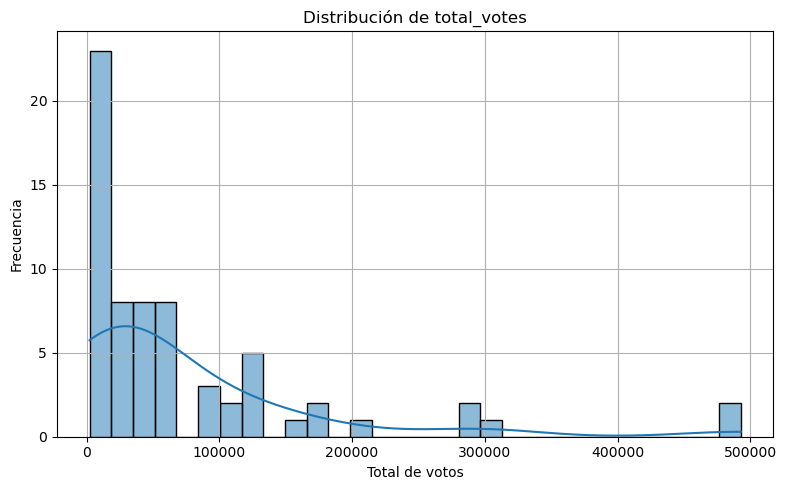

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_subset['total_votes'], bins=30, kde=True)
plt.title("Distribución de total_votes")
plt.xlabel("Total de votos")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


In [133]:
pd.reset_option('display.max_rows')

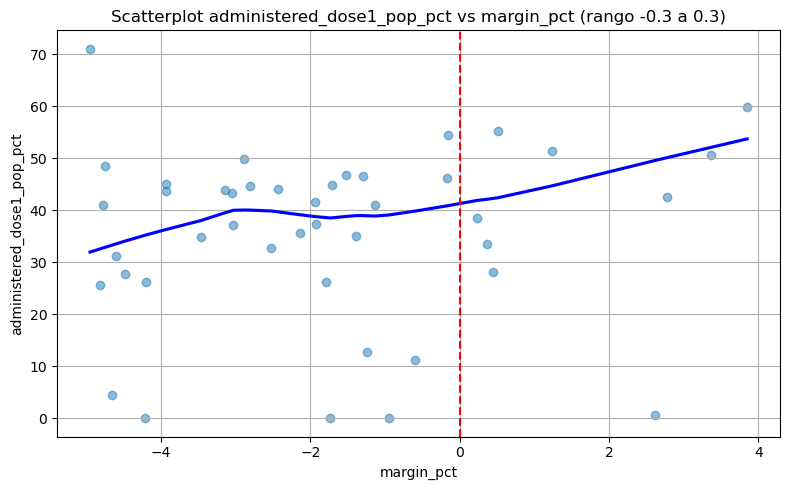

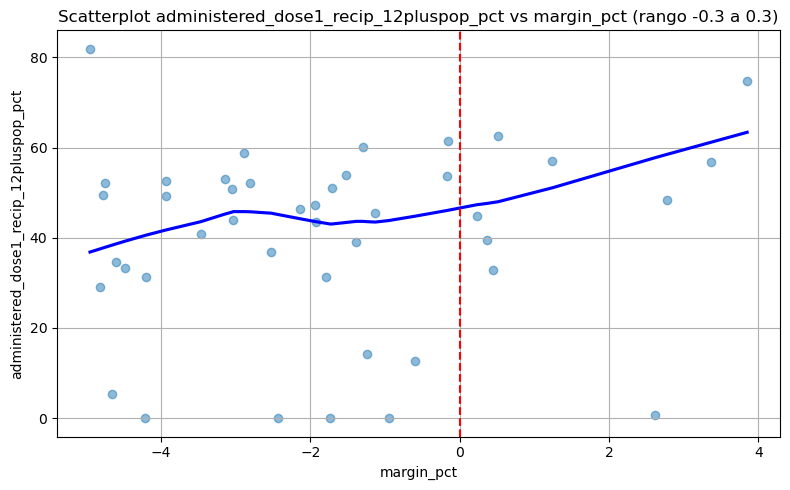

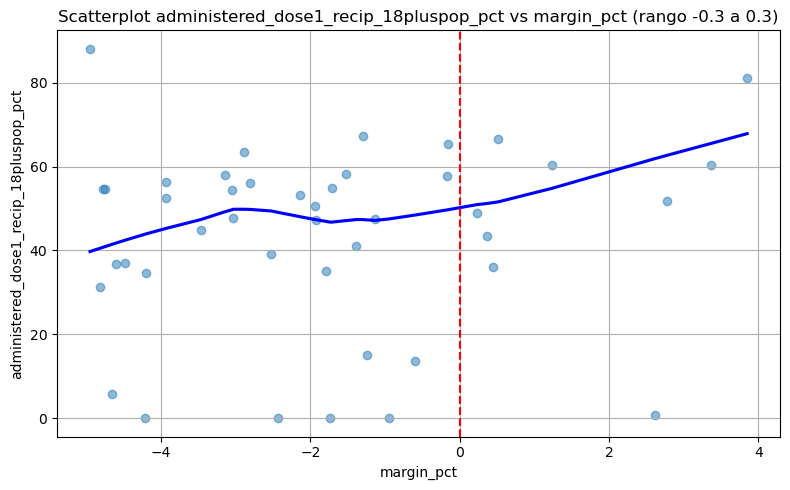

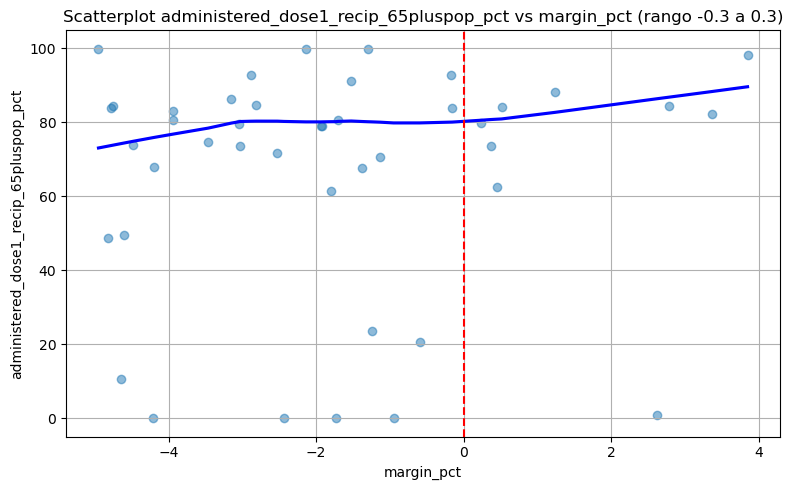

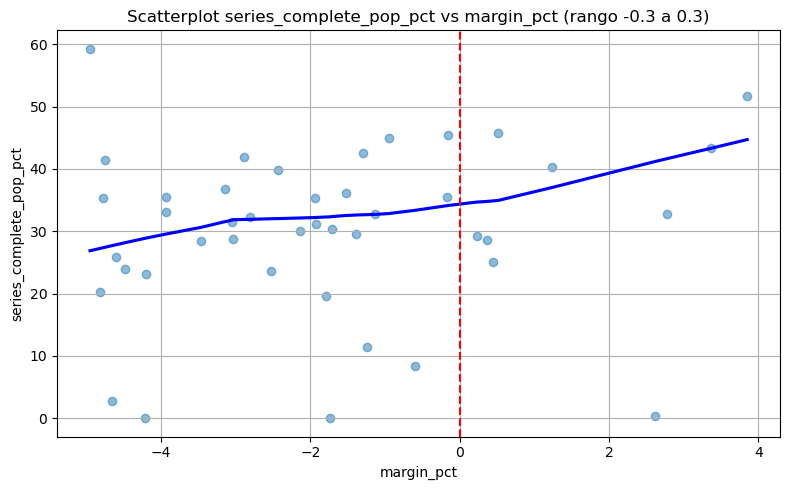

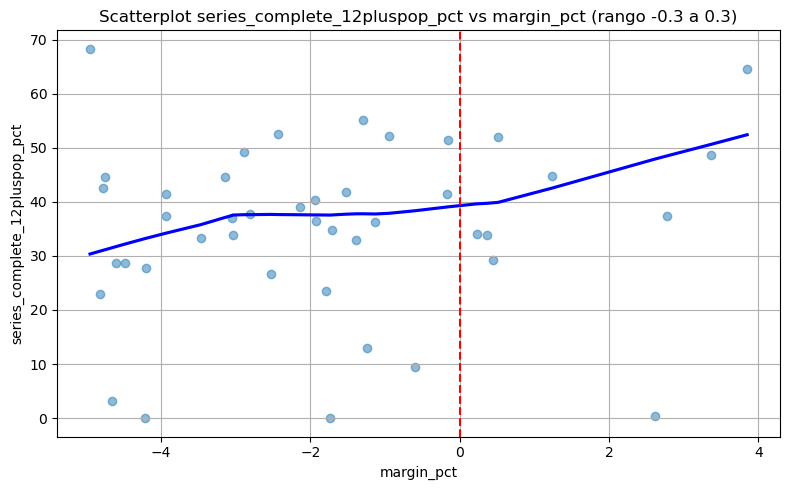

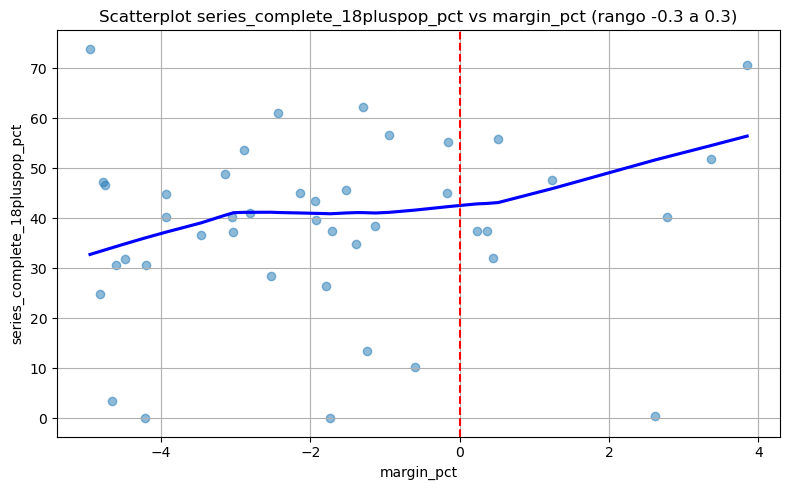

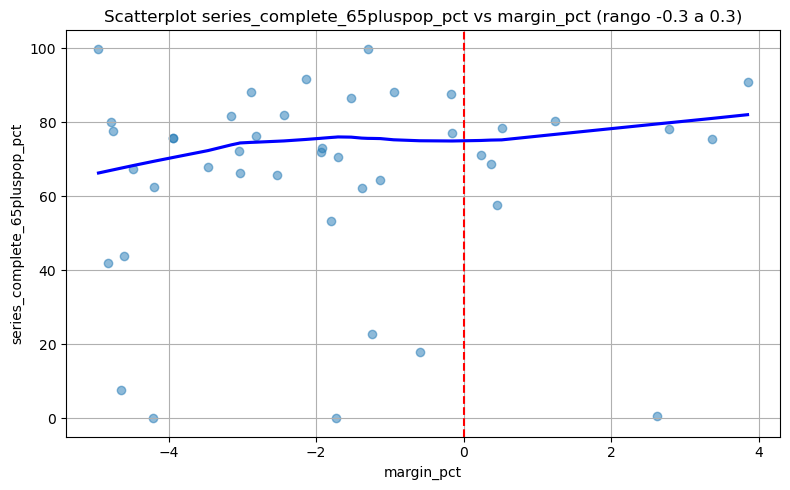

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt


# Graficar cada variable que termina en _pct, filtrando el rango de margin_pct
for col in columnas_pct:
    # Filtrar a los valores entre -0.3 y 0.3
    df_subset = df_filtrado[(df_filtrado['margin_pct'] >= -5) & (df_filtrado['margin_pct'] <= 5)]

    plt.figure(figsize=(8, 5))
    
    # Scatterplot con suavizado lowess
    sns.regplot(
        x='margin_pct',
        y=col,
        data=df_subset,
        lowess=True,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'blue'}
    )
    
    # Línea vertical en 0
    plt.axvline(0, color='red', linestyle='--')
    
    # Títulos y etiquetas
    plt.title(f'Scatterplot {col} vs margin_pct (rango -0.3 a 0.3)')
    plt.xlabel('margin_pct')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [81]:
import statsmodels.formula.api as smf

# Crear interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.025 a 0.025
df1 = df_stata[df_stata["margin_pct"].between(-2, 3)].copy()

# Variables dependientes: terminan en 'pct' y excluyen ciertas columnas
excluir = ['margin_pct', 'completeness_pct']
columnas_pct = [col for col in df1.columns if col.endswith('pct') and col not in excluir]

# Ejecutar regresión para cada variable y guardar resultados
resultados = {}
for col in columnas_pct:
    formula = f"{col} ~ dem_won + margin_pct"
    model = smf.ols(formula, data=df1).fit(cov_type='HC1')
    resultados[col] = model
    print(f"\n==== {col} ====")
    print(model.summary())



==== administered_dose1_pop_pct ====
                                OLS Regression Results                                
Dep. Variable:     administered_dose1_pop_pct   R-squared:                       0.010
Model:                                    OLS   Adj. R-squared:                 -0.069
Method:                         Least Squares   F-statistic:                    0.1669
Date:                        Tue, 27 May 2025   Prob (F-statistic):              0.847
Time:                                20:41:21   Log-Likelihood:                -116.59
No. Observations:                          28   AIC:                             239.2
Df Residuals:                              25   BIC:                             243.2
Df Model:                                   2                                         
Covariance Type:                          HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

In [87]:
import statsmodels.formula.api as smf

# Crear interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.025 a 0.025
df1 = df_stata[df_stata["margin_pct"].between(-5, 5)].copy() # 5 puntos porcentuales

# Variables dependientes: terminan en 'pct' y excluyen ciertas columnas
excluir = ['margin_pct', 'completeness_pct']
columnas_pct = [col for col in df1.columns if col.endswith('pct') and col not in excluir]

# Ejecutar regresión para cada variable y guardar resultados solo si p-value < 0.05
resultados = {}
for col in columnas_pct:
    formula = f"{col} ~ dem_won + margin_pct +T_X + T_X2"
    model = smf.ols(formula, data=df1).fit(cov_type='HC1')
    pval = model.pvalues.get('dem_won', 1.0)
    
    if pval < 0.05:
        resultados[col] = model
        print(f"\n==== {col} ====")
        print(model.summary())


In [91]:

# Crear interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.025 a 0.025
df1 = df_stata[df_stata["margin_pct"].between(-5, 5)].copy() # 5 puntos porcentuales

# Variables dependientes: terminan en 'pct' y excluyen ciertas columnas
excluir = ['margin_pct', 'completeness_pct']
columnas_pct = [col for col in df1.columns if col.endswith('pct') and col not in excluir]

# Ejecutar regresión para cada variable y guardar resultados solo si p-value < 0.05
resultados = {}
for col in columnas_pct:
    formula = f"{col} ~ dem_won  "
    model = smf.ols(formula, data=df1).fit(cov_type='HC1')
    pval = model.pvalues.get('dem_won', 1.0)
    
    if pval < 0.055:
        resultados[col] = model
        print(f"\n==== {col} ====")
        print(model.summary())


In [92]:
import statsmodels.formula.api as smf
import numpy as np
# Excluir columnas específicas
excluir = ['margin_pct', 'completeness_pct']

# Seleccionar columnas que terminan en 'pct' y no están en la lista de exclusión
columnas_pct = [col for col in df_stata.columns if col.endswith('pct') and col not in excluir]

# Asegurarse de que las columnas estén en formato numérico
df_stata[columnas_pct] = df_stata[columnas_pct].apply(pd.to_numeric, errors='coerce')

# Crear columnas logarítmicas (solo para valores > 0)
for col in columnas_pct:
    log_col = f'log_{col}'
    df_stata[log_col] = np.where(df_stata[col] > 0, np.log(df_stata[col]), np.nan)
# Lista de variables logarítmicas que acabamos de crear
log_columnas = [f'log_{col}' for col in columnas_pct if f'log_{col}' in df_stata.columns]




C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result

In [97]:
# Filtrar el rango para RD (por ejemplo -2.5% a +2.5%)
df1 = df_stata[df_stata["margin_pct"].between(-5, 5)]

# Crear X y su interacción
df1["X2"] = df1["margin_pct"] ** 2
df1["T_X"] = df1["margin_pct"] * df1["dem_won"]
df1["T_X2"] = df1["X2"] * df1["dem_won"]

# Correr una regresión para cada variable logarítmica
import statsmodels.formula.api as smf

for col in log_columnas:
    model = smf.ols(f"{col} ~ dem_won + margin_pct", data=df1).fit(cov_type='HC1')
    pval = model.pvalues.get('dem_won', 1.0)  # valor p, por defecto 1.0 si no está

    if pval < 0.05:
        print(f"\n### Regressing {col} ~ dem_won + margin_pct+T_X+T_X2")
        print(model.summary())



C:\Users\HP\AppData\Local\Temp\ipykernel_29620\114603525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["X2"] = df1["margin_pct"] ** 2
C:\Users\HP\AppData\Local\Temp\ipykernel_29620\114603525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["T_X"] = df1["margin_pct"] * df1["dem_won"]
C:\Users\HP\AppData\Local\Temp\ipykernel_29620\114603525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [96]:
df1["margin_pct"]

4       3.813563
33     -1.564742
50     -1.796912
117    -4.651904
169    -2.887290
          ...   
2036    2.780583
2038   -4.058205
2045   -4.779250
2052   -3.973116
2082   -1.238147
Name: margin_pct, Length: 66, dtype: float64

# Ahora variables de 2023

In [ ]:
#dos razones: disponibilidad de datos, termina plan de vacunacion y elecciones son en 2024

In [213]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cdc.gov,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("8xkx-amqh", limit=4000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [214]:
df_unico_fips = vacunas.drop_duplicates(subset='fips', keep='first')

In [215]:
df_stata2023 = pd.merge(df_merged, df_unico_fips, on='fips', how='inner')
df_stata2023.to_stata('baselimpiavac2023.dta', write_index=False)
df_stata2023

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\io\stata.py:2491: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    administered_dose1_recip_12pluspop_pct   ->   administered_dose1_recip_12plusp
    administered_dose1_recip_18pluspop_pct   ->   administered_dose1_recip_18plusp
    administered_dose1_recip_65pluspop_pct   ->   administered_dose1_recip_65plusp
    series_complete_12pluspop_pct_svi   ->   series_complete_12pluspop_pct_sv
    series_complete_18pluspop_pct_svi   ->   series_complete_18pluspop_pct_sv
    series_complete_65pluspop_pct_svi   ->   series_complete_65pluspop_pct_sv
    series_complete_pop_pct_ur_equity   ->   series_complete_pop_pct_ur_equit
    series_complete_12pluspop_pct_ur_equity   ->   series_complete_12pluspop_pct_ur
    series_complete_18pluspop_pct_ur_equity   ->   series_complete_18pluspop_pct_ur
    series_complete_65pluspop_pct_ur_equity  

dem_won2016   fips  margin_pct2016  geoid t_county_name  total_votes  \
0               1  12001       22.519499  12001       Alachua       142604   
1               0  12003      -64.761754  12003         Baker        14059   
2               1  12011       35.053723  12011       Broward       957672   
3               0  12013      -56.222186  12013       Calhoun         6526   
4               1  12031       -1.500697  12031         Duval       492820   
...           ...    ...             ...    ...           ...          ...   
2122            0  56033      -51.737506  56033      Sheridan        16428   
2123            0  56035      -64.347219  56035      Sublette         4970   
2124            0  56041      -61.492611  56041         Uinta         9402   
2125            0  56043      -64.037685  56043      Washakie         4012   
2126            0  56045      -78.104379  56045        Weston         3542   

     t_state_name  votes_gop  votes_dem  dem_won  ...  \
0         Florida      50972      89704        1  ...   
1         Florida      11911       2037        0  ...   
2         Florida     333409     618752        1  ...   
3         Florida       5274       1209        0  ...   
4         Florida     233762     252556        1  ...   
...           ...        ...        ...      ...  ...   
2122      Wyoming      11843       4043        0  ...   
2123      Wyoming       3957        882        0  ...   
2124      Wyoming       7496       1591        0  ...   
2125      Wyoming       3245        651        0  ...   
2126      Wyoming       3107        360        0  ...   

      series_complete_18pluspop_pct_svi  series_complete_65pluspop_pct_svi  \
0                                     7                                  8   
1                                     9                                 11   
2                                    10                                 11   
3                                    13                                 15   
4                                    10                                 12   
...                                 ...                                ...   
2122                                  3                                  4   
2123                                  1                                  2   
2124                                  6                                  7   
2125                                  6                                  7   
2126                                  5                                  7   

      metro_status  series_complete_pop_pct_ur_equity  \
0            Metro                                  2   
1            Metro                                  1   
2            Metro                                  1   
3        Non-metro                                  5   
4            Metro                                  1   
...            ...                                ...   
2122     Non-metro                                  6   
2123     Non-metro                                  5   
2124     Non-metro                                  5   
2125     Non-metro                                  5   
2126     Non-metro                                  5   

      series_complete_12pluspop_pct_ur_equity  \
0                                           2   
1                                           1   
2                                           2   
3                                           5   
4                                           2   
...                                       ...   
2122                                        6   
2123                                        5   
2124                                        5   
2125                                        6   
2126                                        5   

      series_complete_18pluspop_pct_ur_equity  \
0                                           3   
1                                           1   
2                         

In [217]:
diff = df_stata2021['series_complete_65pluspop_pct_svi'] != df_stata2023['series_complete_65pluspop_pct_svi']
print(df_stata2021[diff])


      dem_won2016   fips  margin_pct2016  geoid t_county_name  total_votes  \
686             1  25001       13.409514  25001    Barnstable       150325   
1239            1  35039       40.299316  35039    Rio Arriba        16628   
1664            0  48001      -58.074258  48001      Anderson        19227   
1665            0  48005      -47.298293  48005      Angelina        34574   
1666            0  48007      -50.367823  48007       Aransas        12290   
...           ...    ...             ...    ...           ...          ...   
1876            0  48501      -59.634624  48501        Yoakum         2631   
1877            0  48503      -74.614782  48503         Young         8239   
1878            0  48505       32.801532  48505        Zapata         3874   
1915            0  51530      -30.855950  51530   Buena Vista         2776   
1921            0  51580      -18.362178  51580     Covington         2603   

       t_state_name  votes_gop  votes_dem  dem_won  ...  \
686 

In [111]:
election_data_df2016.rename(columns={"combined_fips": "fips","margin_pct": "margin_pct2016" }, inplace=True)
election_data_df2016['fips'] = election_data_df2016['fips'].astype(str)
df_merged = pd.merge(election_data_df2016[['dem_won2016', 'fips', 'margin_pct2016' ]], election_data_df, on='fips', how='inner')
df_filtrado = df_merged[ df_merged["dem_won"] == df_merged["dem_won2016"]]
df_stata = pd.merge(df_filtrado, df_unico_fips, on='fips', how='inner')
df_stata 

dem_won2016   fips  margin_pct2016  geoid      t_county_name  \
0               1  12001       22.519499  12001            Alachua   
1               0  12003      -64.761754  12003              Baker   
2               1  12011       35.053723  12011            Broward   
3               0  12013      -56.222186  12013            Calhoun   
4               1  12031       -1.500697  12031              Duval   
5               0  12037      -39.663502  12037           Franklin   
6               1  12039       37.469994  12039            Gadsden   
7               0  12041      -62.758375  12041          Gilchrist   
8               0  12043      -39.609644  12043             Glades   
9               0  12045      -49.526034  12045               Gulf   
10              0  12047      -28.251697  12047           Hamilton   
11              0  12051      -14.244552  12051             Hendry   
12              0  12053      -28.985492  12053           Hernando   
13              0  12055      -32.042817  12055          Highlands   
14              0  12059      -77.874442  12059             Holmes   
15              0  12061      -24.490281  12061       Indian River   
16              0  12063      -37.376768  12063            Jackson   
17              0  12065       -5.143306  12065          Jefferson   
18              0  12069      -23.126229  12069               Lake   
19              0  12071      -20.385700  12071                Lee   
20              0  12077      -57.389985  12077            Liberty   
21              0  12079      -15.559214  12079            Madison   
22              0  12081      -17.149243  12081            Manatee   
23              0  12083      -26.221165  12083             Marion   
24              0  12085      -26.852964  12085             Martin   
25              0  12087       -6.918980  12087             Monroe   
26              0  12089      -50.222404  12089             Nassau   
27              0  12093      -39.531984  12093         Okeechobee   
28              0  12101      -21.570590  12101              Pasco   
29              0  12105      -14.105021  12105               Polk   
30              0  12113      -53.444963  12113         Santa Rosa   
31              0  12115      -11.562783  12115           Sarasota   
32              0  12109      -33.430113  12109          St. Johns   
33              0  12111       -2.441537  12111          St. Lucie   
34              0  12119      -39.258177  12119             Sumter   
35              0  12123      -51.449510  12123             Taylor   
36              0  12125      -62.409977  12125              Union   
37              0  12127      -13.050126  12127            Volusia   
38              0  12129      -40.139468  12129            Wakulla   
39              0  13003      -45.199693  13003           Atkinson   
40              0  13007       -8.680556  13007              Baker   
41              0  13011      -78.404837  13011              Banks   
42              0  13013      -50.385042  13013             Barrow   
43              0  13017      -27.621138  13017           Ben Hill   
44              0  13019      -66.539692  13019            Berrien   
45              0  13023      -53.161735  13023           Bleckley   
46              0  13025      -78.631663  13025           Brantley   
47              0  13027      -18.746011  13027             Brooks   
48              0  13029      -43.172011  13029              Bryan   
49              0  13031      -23.452445  13031            Bulloch   
50              0  13033        2.556150  13033              Burke   
51              0  13035      -43.800781  13035              Butts   
52              0  13039      -33.853918  13039             Camden   
53              0  13043      -43.598616  13043            Candler   
54              0  13045      -40.144934  13045            Carroll   
55              0  13049      -48.552894  13049           Charlton   
56              

In [117]:
# Columnas que no queremos procesar
excluir = ['date', 'fips', 'mmwr_week', 'recip_county', 'recip_state', 'dem_won']

# Seleccionamos columnas que terminan en 'pct' y no están en la lista de exclusión
columnas_pct = [col for col in df_stata.columns if col.endswith('pct') and col not in excluir]

# Convertimos esas columnas a numéricas, forzando donde sea necesario
df_stata[columnas_pct] = df_stata[columnas_pct].apply(pd.to_numeric, errors='coerce')


# Calculamos los promedios por grupo
promedios = df_stata.groupby('dem_won')[columnas_pct].mean()

# Calculamos la diferencia: promedio(dem_won=1) - promedio(dem_won=0)
diferencia = promedios.loc[1] - promedios.loc[0]

# Mostramos resultados ordenados por magnitud de la diferencia
diferencia = diferencia.sort_values(ascending=False)

In [118]:
import statsmodels.formula.api as smf

# Crear interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.025 a 0.025
df1 = df_stata[df_stata["margin_pct"].between(-5, 5)].copy() # 5 puntos porcentuales

# Variables dependientes: terminan en 'pct' y excluyen ciertas columnas
excluir = ['margin_pct', 'completeness_pct']
columnas_pct = [col for col in df1.columns if col.endswith('pct') and col not in excluir]

# Ejecutar regresión para cada variable y guardar resultados solo si p-value < 0.05
resultados = {}
for col in columnas_pct:
    formula = f"{col} ~ dem_won"
    model = smf.ols(formula, data=df1).fit(cov_type='HC1')
    pval = model.pvalues.get('dem_won', 1.0)
    
    if pval < 0.05:
        resultados[col] = model
        print(f"\n==== {col} ====")
        print(model.summary())

In [119]:
import statsmodels.formula.api as smf

# Crear interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.025 a 0.025
df1 = df_stata[df_stata["margin_pct"].between(-5, 5)].copy() # 5 puntos porcentuales

# Variables dependientes: terminan en 'pct' y excluyen ciertas columnas
excluir = ['margin_pct', 'completeness_pct']
columnas_pct = [col for col in df1.columns if col.endswith('pct') and col not in excluir]

# Ejecutar regresión para cada variable y guardar resultados solo si p-value < 0.05
resultados = {}
for col in columnas_pct:
    formula = f"{col} ~ dem_won + margin_pct"
    model = smf.ols(formula, data=df1).fit(cov_type='HC1')
    pval = model.pvalues.get('dem_won', 1.0)
    
    if pval < 0.05:
        resultados[col] = model
        print(f"\n==== {col} ====")
        print(model.summary())

In [120]:
import statsmodels.formula.api as smf

# Crear interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.025 a 0.025
df1 = df_stata[df_stata["margin_pct"].between(-5, 5)].copy() # 5 puntos porcentuales

# Variables dependientes: terminan en 'pct' y excluyen ciertas columnas
excluir = ['margin_pct', 'completeness_pct']
columnas_pct = [col for col in df1.columns if col.endswith('pct') and col not in excluir]

# Ejecutar regresión para cada variable y guardar resultados solo si p-value < 0.05
resultados = {}
for col in columnas_pct:
    formula = f"{col} ~ dem_won + margin_pct +T_X"
    model = smf.ols(formula, data=df1).fit(cov_type='HC1')
    pval = model.pvalues.get('dem_won', 1.0)
    
    if pval < 0.05:
        resultados[col] = model
        print(f"\n==== {col} ====")
        print(model.summary())

In [122]:
import statsmodels.formula.api as smf

# Crear interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.025 a 0.025
df1 = df_stata[df_stata["margin_pct"].between(-5, 5)].copy() # 5 puntos porcentuales

# Variables dependientes: terminan en 'pct' y excluyen ciertas columnas
excluir = ['margin_pct', 'completeness_pct']
columnas_pct = [col for col in df1.columns if col.endswith('pct') and col not in excluir]

# Ejecutar regresión para cada variable y guardar resultados solo si p-value < 0.05
resultados = {}
for col in columnas_pct:
    formula = f"{col} ~ dem_won + margin_pct +T_X + T_X2"
    model = smf.ols(formula, data=df1).fit(cov_type='HC1')
    pval = model.pvalues.get('dem_won', 1.0)
    
    if pval < 5:
        resultados[col] = model
        print(f"\n==== {col} ====")
        print(model.summary())


==== administered_dose1_pop_pct ====
                                OLS Regression Results                                
Dep. Variable:     administered_dose1_pop_pct   R-squared:                       0.058
Model:                                    OLS   Adj. R-squared:                 -0.004
Method:                         Least Squares   F-statistic:                     2.908
Date:                        Tue, 27 May 2025   Prob (F-statistic):             0.0287
Time:                                21:11:25   Log-Likelihood:                -272.79
No. Observations:                          66   AIC:                             555.6
Df Residuals:                              61   BIC:                             566.5
Df Model:                                   4                                         
Covariance Type:                          HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

In [125]:
import statsmodels.formula.api as smf

# Crear interacciones
df_stata["X2"] = df_stata["margin_pct"] ** 2
df_stata["T_X"] = df_stata["margin_pct"] * df_stata["dem_won"]
df_stata["T_X2"] = df_stata["X2"] * df_stata["dem_won"]

# Filtrar el rango de -0.025 a 0.025
df1 = df_stata[df_stata["margin_pct"].between(-7.5, 7.5)].copy() # 5 puntos porcentuales

# Variables dependientes: terminan en 'pct' y excluyen ciertas columnas
excluir = ['margin_pct', 'completeness_pct']
columnas_pct = [col for col in df1.columns if col.endswith('pct') and col not in excluir]

# Ejecutar regresión para cada variable y guardar resultados solo si p-value < 0.05
resultados = {}
for col in columnas_pct:
    formula = f"{col} ~ dem_won"
    model = smf.ols(formula, data=df1).fit(cov_type='HC1')
    pval = model.pvalues.get('dem_won', 1.0)
    
    if pval < 5:
        resultados[col] = model
        print(f"\n==== {col} ====")
        print(model.summary())


==== administered_dose1_pop_pct ====
                                OLS Regression Results                                
Dep. Variable:     administered_dose1_pop_pct   R-squared:                       0.013
Model:                                    OLS   Adj. R-squared:                  0.002
Method:                         Least Squares   F-statistic:                     1.392
Date:                        Tue, 27 May 2025   Prob (F-statistic):              0.241
Time:                                21:13:52   Log-Likelihood:                -397.29
No. Observations:                          96   AIC:                             798.6
Df Residuals:                              94   BIC:                             803.7
Df Model:                                   1                                         
Covariance Type:                          HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

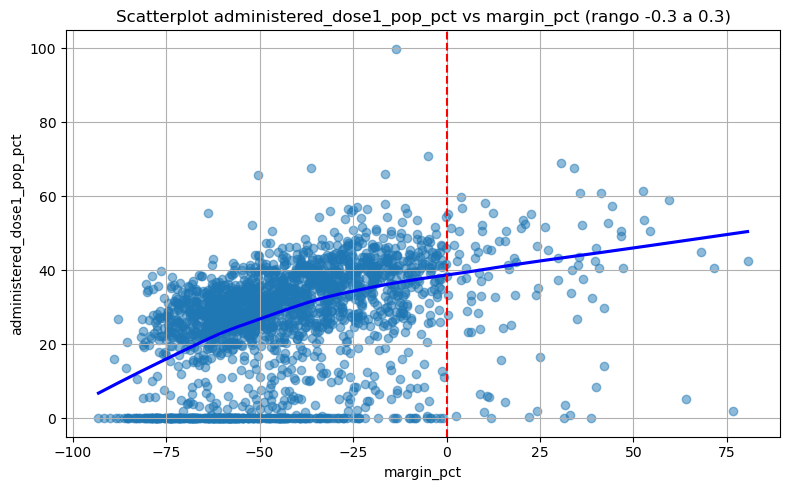

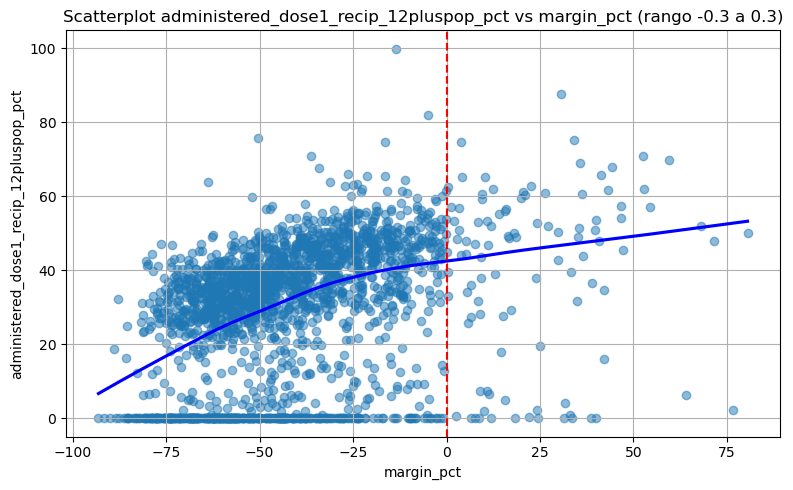

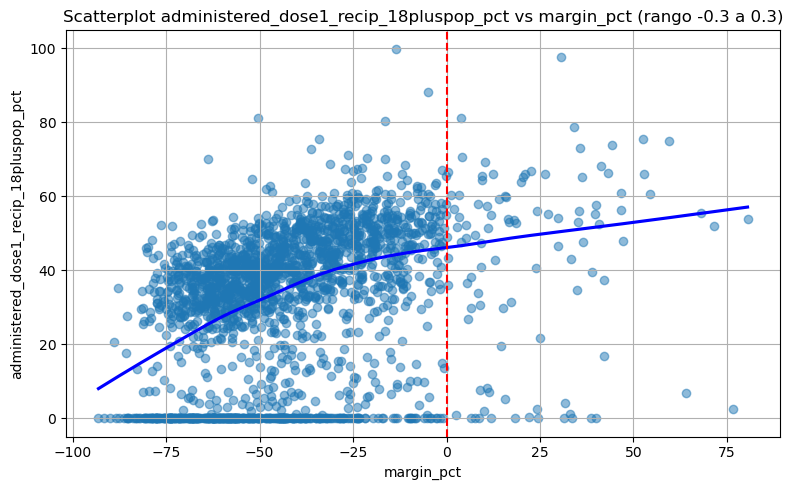

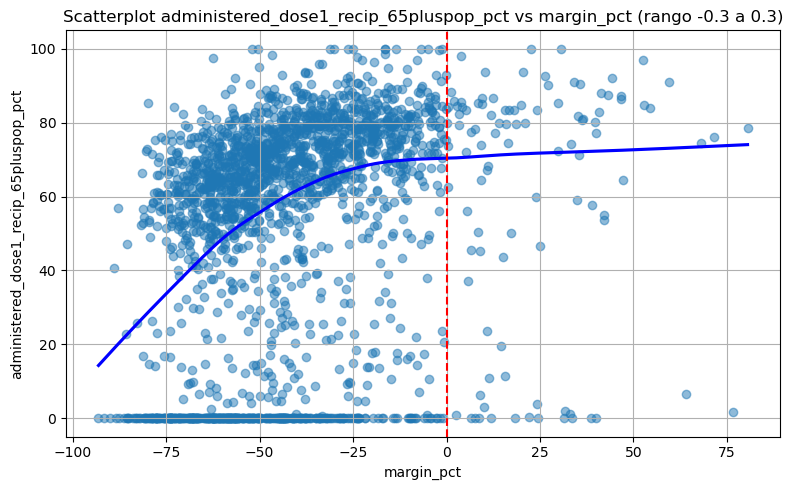

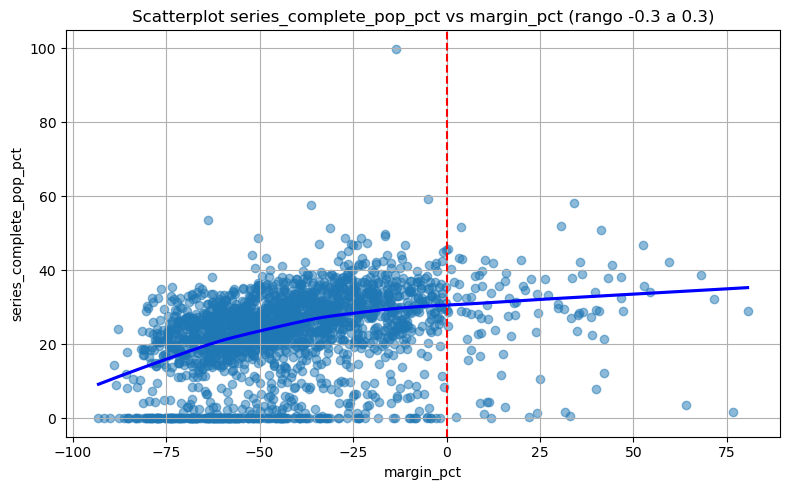

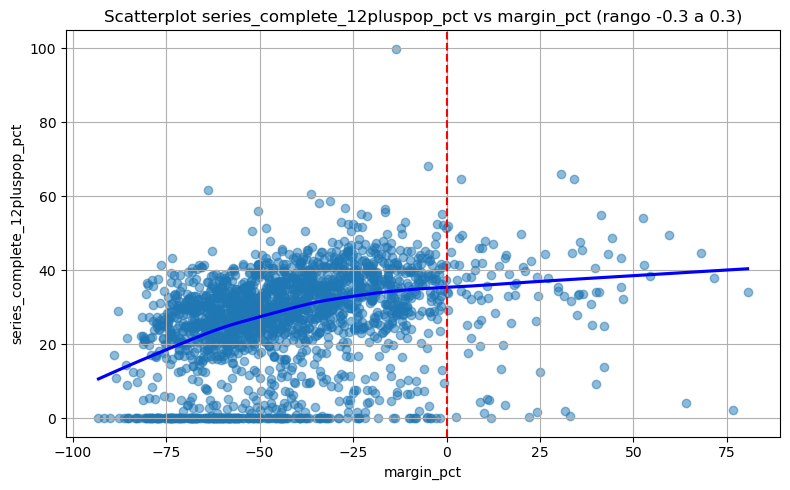

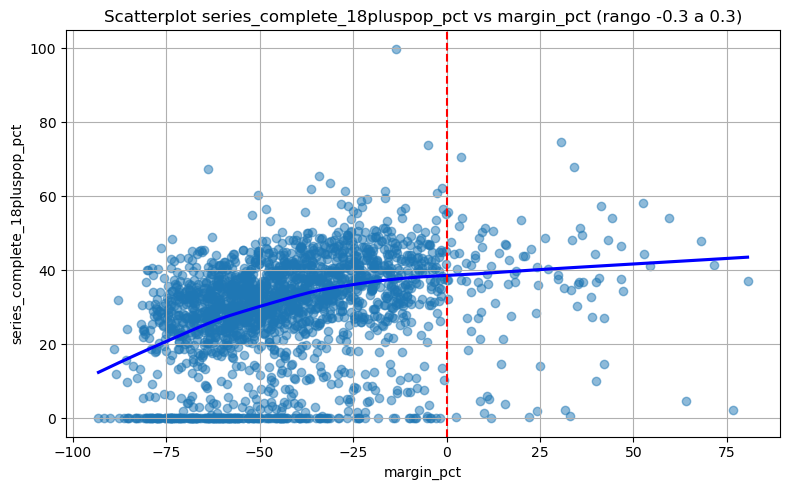

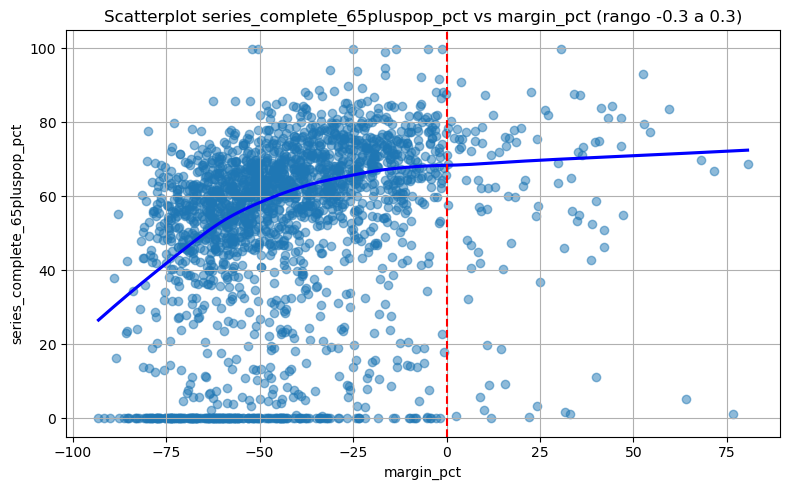

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt


# Graficar cada variable que termina en _pct, filtrando el rango de margin_pct
for col in columnas_pct:
    # Filtrar a los valores entre -0.3 y 0.3
    df_subset = df_stata[(df_stata['margin_pct'] >= -100) & (df_stata['margin_pct'] <= 100)]

    plt.figure(figsize=(8, 5))
    
    # Scatterplot con suavizado lowess
    sns.regplot(
        x='margin_pct',
        y=col,
        data=df_subset,
        lowess=True,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'blue'}
    )
    
    # Línea vertical en 0
    plt.axvline(0, color='red', linestyle='--')
    
    # Títulos y etiquetas
    plt.title(f'Scatterplot {col} vs margin_pct (rango -0.3 a 0.3)')
    plt.xlabel('margin_pct')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [132]:
print(df_stata["dem_won"].value_counts(dropna=False))


0    2023
1     104
Name: dem_won, dtype: int64


In [6]:
import requests
import pandas as pd

# Tu API key
API_KEY = '29caaead12373544ff9fb7db17cb01532b2e2468'


# Año y dataset: American Community Survey 5-year estimates
year = '2021'
dataset = 'acs/acs5'

variables = {
    'B01003_001E': 'total_population',
    'B19013_001E': 'median_income',
    'B17001_002E': 'population_below_poverty',
    'B01001_020E': 'males_65_66',    
    'B01001_021E': 'males_67_69',
    'B01001_044E': 'females_65_66',
    'B01001_045E': 'females_67_69',
    'B15003_022E': 'bachelor_degree',
    'B27010_017E': 'uninsured_total', 
    'C24050_002E': 'healthcare_employed',
    'B02001_002E': 'white_alone',
    'B02001_003E': 'black_alone',
    'B03003_003E': 'hispanic' 
}

var_string = ",".join(variables.keys())

 
url = f"https://api.census.gov/data/{year}/{dataset}?get=NAME,{var_string}&for=county:*&in=state:*&key={API_KEY}"

 
response = requests.get(url)

 
data = response.json()
columns = data[0]
rows = data[1:]
df = pd.DataFrame(rows, columns=columns)

 
print(df.head())


                      NAME B01003_001E B19013_001E B17001_002E B01001_020E  \
0  Autauga County, Alabama       58239       62660        7847         539   
1  Baldwin County, Alabama      227131       64346       20598        3257   
2  Barbour County, Alabama       25259       36422        5890         297   
3     Bibb County, Alabama       22412       54277        3558         265   
4   Blount County, Alabama       58884       52830        7720         589   

  B01001_021E B01001_044E B01001_045E B15003_022E B27010_017E C24050_002E  \
0         697         444         947        6507         300         200   
1        3777        3082        4624       33379        2984        1827   
2         423         199         612        1212         154         469   
3         363         173         457        1276          94         299   
4        1100         600        1091        3783         484         443   

  B02001_002E B02001_003E B03003_003E state county  
0       43755  

In [7]:
# Renombrar columnas
df = df.rename(columns=variables)

# Convertir columnas numéricas
for col in variables.values():
    df[col] = pd.to_numeric(df[col], errors='coerce')

df

NAME  total_population  median_income  \
0              Autauga County, Alabama             58239          62660   
1              Baldwin County, Alabama            227131          64346   
2              Barbour County, Alabama             25259          36422   
3                 Bibb County, Alabama             22412          54277   
4               Blount County, Alabama             58884          52830   
...                                ...               ...            ...   
3216  Vega Baja Municipio, Puerto Rico             54544          21507   
3217    Vieques Municipio, Puerto Rico              8317          14942   
3218   Villalba Municipio, Puerto Rico             22341          20722   
3219    Yabucoa Municipio, Puerto Rico             31047          17267   
3220      Yauco Municipio, Puerto Rico             34704          16444   

      population_below_poverty  males_65_66  males_67_69  females_65_66  \
0                         7847          539          697            444   
1                        20598         3257         3777           3082   
2                         5890          297          423            199   
3                         3558          265          363            173   
4                         7720          589         1100            600   
...                        ...          ...          ...            ...   
3216                     23520          371          831            689   
3217                      4425          257          159            101   
3218                      9881          177          356            366   
3219                     16335          346          630            328   
3220                     16048          436          766            430   

      females_67_69  bachelor_degree  uninsured_total  healthcare_employed  \
0               947             6507              300                  200   
1              4624            33379             2984                 1827   
2               612             1212              154                  469   
3               457             1276               94                  299   
4              1091             3783              484                  443   
...             ...              ...              ...                  ...   
3216            960             6627              987                  136   
3217            157              424                0                   15   
3218            353             2658               77                  231   
3219            846             3353              114                   56   
3220            739             5090              164                  194   

      white_alone  black_alone  hispanic state county  
0           43755        11470      1775    01    001  
1          192034        19895     10634    01    003  
2           11495        11985      1176    01    005  
3           17020         5003       634    01    007  
4           54439          760      5612    01    009  
...           ...          ...       ...   ...    ...  
3216        30690         2409     53313    72    145  
3217         2592          629      7662    72    147  
3218        10502         1784     22259    72    149  
3219         3190        16119     31009    72    151  
3220        24533         1282     34341    72    153  

[3221 rows x 16 columns]

In [135]:
# Renombrar columnas
df = df.rename(columns=variables)

# Convertir columnas numéricas
for col in variables.values():
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear columna fips (2 dígitos state + 3 dígitos county)
df['fips'] = df['state'].str.zfill(2) + df['county'].str.zfill(3)

# Calcular adultos mayores 65+
df['adults_65plus'] = df['males_65_66'] + df['males_67_69'] + df['females_65_66'] + df['females_67_69']
df['pct_adults_65plus'] = df['adults_65plus'] / df['total_population']

# Porcentaje con educación universitaria
df['pct_bachelor_degree'] = df['bachelor_degree'] / df['total_population']

# Porcentaje sin seguro médico
df['pct_uninsured'] = df['uninsured_total'] / df['total_population']

df['pct_healthcare_employed'] = df['healthcare_employed'] / df['total_population']

In [137]:
df['fips'] = df['state'].astype(str).str.zfill(2) + df['county'].astype(str).str.zfill(3)
df=df[['fips', 'pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed']]

In [153]:
df

fips  pct_adults_65plus  pct_bachelor_degree  pct_uninsured  \
0     01001           0.045107             0.111729       0.005151   
1     01003           0.064896             0.146959       0.013138   
2     01005           0.060612             0.047983       0.006097   
3     01007           0.056131             0.056934       0.004194   
4     01009           0.057401             0.064245       0.008220   
...     ...                ...                  ...            ...   
3216  72145           0.052270             0.121498       0.018095   
3217  72147           0.081039             0.050980       0.000000   
3218  72149           0.056040             0.118974       0.003447   
3219  72151           0.069250             0.107998       0.003672   
3220  72153           0.068321             0.146669       0.004726   

      pct_healthcare_employed  
0                    0.003434  
1                    0.008044  
2                    0.018568  
3                    0.013341  
4                    0.007523  
...                       ...  
3216                 0.002493  
3217                 0.001804  
3218                 0.010340  
3219                 0.001804  
3220                 0.005590  

[3221 rows x 5 columns]

In [138]:
df_unico_fips

date   fips mmwr_week       recip_county recip_state  \
0     2021-05-01T00:00:00.000  37059        17       Davie County          NC   
1     2021-05-01T00:00:00.000  17189        17  Washington County          IL   
2     2021-05-01T00:00:00.000  06029        17        Kern County          CA   
3     2021-05-01T00:00:00.000  51580        17     Covington city          VA   
4     2021-05-01T00:00:00.000  36111        17      Ulster County          NY   
...                       ...    ...       ...                ...         ...   
3277  2021-05-01T00:00:00.000  28041        17      Greene County          MS   
3278  2021-05-01T00:00:00.000  55065        17   Lafayette County          WI   
3279  2021-05-01T00:00:00.000  38025        17        Dunn County          ND   
3280  2021-05-01T00:00:00.000  05089        17      Marion County          AR   
3281  2021-05-01T00:00:00.000  17163        17   St. Clair County          IL   

     completeness_pct administered_dose1_recip administered_dose1_pop_pct  \
0                96.4                    17006                       39.7   
1                97.6                     5728                       41.2   
2                96.9                   276004                       30.7   
3                   0                        0                          0   
4                97.2                    89312                       50.3   
...               ...                      ...                        ...   
3277             98.6                     3363                       24.8   
3278             97.2                     7397                       44.4   
3279             95.7                      769                       17.4   
3280             89.1                     4181                         25   
3281             97.6                   113757                       43.8   

     administered_dose1_recip_12plus administered_dose1_recip_12pluspop_pct  \
0                              17004                                   45.6   
1                               5727                                   47.6   
2                             275946                                   37.9   
3                                  0                                    0.0   
4                              89308                                   56.5   
...                              ...                                    ...   
3277                            3363                                   28.2   
3278                            7396                                   52.5   
3279                             769                                   21.1   
3280                            4181                                   28.4   
3281                          113745                                   51.8   

      ... series_complete_18pluspop_pct_svi series_complete_65pluspop_pct_svi  \
0     ...                                 7                                 7   
1     ...                                 3                                 3   
2     ...                                14                                15   
3     ...                               NaN                               NaN   
4     ...                                 7                                 7   
...   ...                               ...                               ...   
3277  ...                                 9                                10   
3278  ...                                 4                                 4   
3279  ...                                 1                                 2   
3280  ...                                 9                                10   
3281  ...                                11                                11   

     metro_status series_complete_pop_pct_ur_equity  \
0           Metro                                 2   
1       Non-metro                                 6   
2           Metro                       

In [144]:
df_merged = pd.merge(df_filtrado, df, on='fips', how='inner')
df_merged

dem_won2016   fips  margin_pct2016  geoid t_county_name  total_votes  \
0               1  12001       22.519499  12001       Alachua       142604   
1               0  12003      -64.761754  12003         Baker        14059   
2               1  12011       35.053723  12011       Broward       957672   
3               0  12013      -56.222186  12013       Calhoun         6526   
4               1  12031       -1.500697  12031         Duval       492820   
...           ...    ...             ...    ...           ...          ...   
2122            0  56033      -51.737506  56033      Sheridan        16428   
2123            0  56035      -64.347219  56035      Sublette         4970   
2124            0  56041      -61.492611  56041         Uinta         9402   
2125            0  56043      -64.037685  56043      Washakie         4012   
2126            0  56045      -78.104379  56045        Weston         3542   

     t_state_name  votes_gop  votes_dem  dem_won  margin_votes  margin_pct  \
0         Florida      50972      89704        1       3873200   27.160528   
1         Florida      11911       2037        0       -987400  -70.232591   
2         Florida     333409     618752        1      28534300   29.795483   
3         Florida       5274       1209        0       -406500  -62.289304   
4         Florida     233762     252556        1       1879400    3.813563   
...           ...        ...        ...      ...           ...         ...   
2122      Wyoming      11843       4043        0       -780000  -47.479912   
2123      Wyoming       3957        882        0       -307500  -61.871227   
2124      Wyoming       7496       1591        0       -590500  -62.805786   
2125      Wyoming       3245        651        0       -259400  -64.656032   
2126      Wyoming       3107        360        0       -274700  -77.555054   

      pct_adults_65plus  pct_bachelor_degree  pct_uninsured  \
0              0.051439             0.142415       0.008705   
1              0.052851             0.062243       0.026711   
2              0.052710             0.150673       0.020256   
3              0.056553             0.054606       0.028132   
4              0.050230             0.144213       0.016545   
...                 ...                  ...            ...   
2122           0.066922             0.126834       0.013891   
2123           0.059570             0.144734       0.019139   
2124           0.056059             0.079458       0.019694   
2125           0.078399             0.120366       0.006694   
2126           0.065738             0.098389       0.033812   

      pct_healthcare_employed  
0                    0.004251  
1                    0.001821  
2                    0.001211  
3                    0.019188  
4                    0.001023  
...                       ...  
2122                 0.039984  
2123                 0.131144  
2124                 0.043093  
2125                 0.043254  
2126                 0.109128  

[2127 rows x 16 columns]

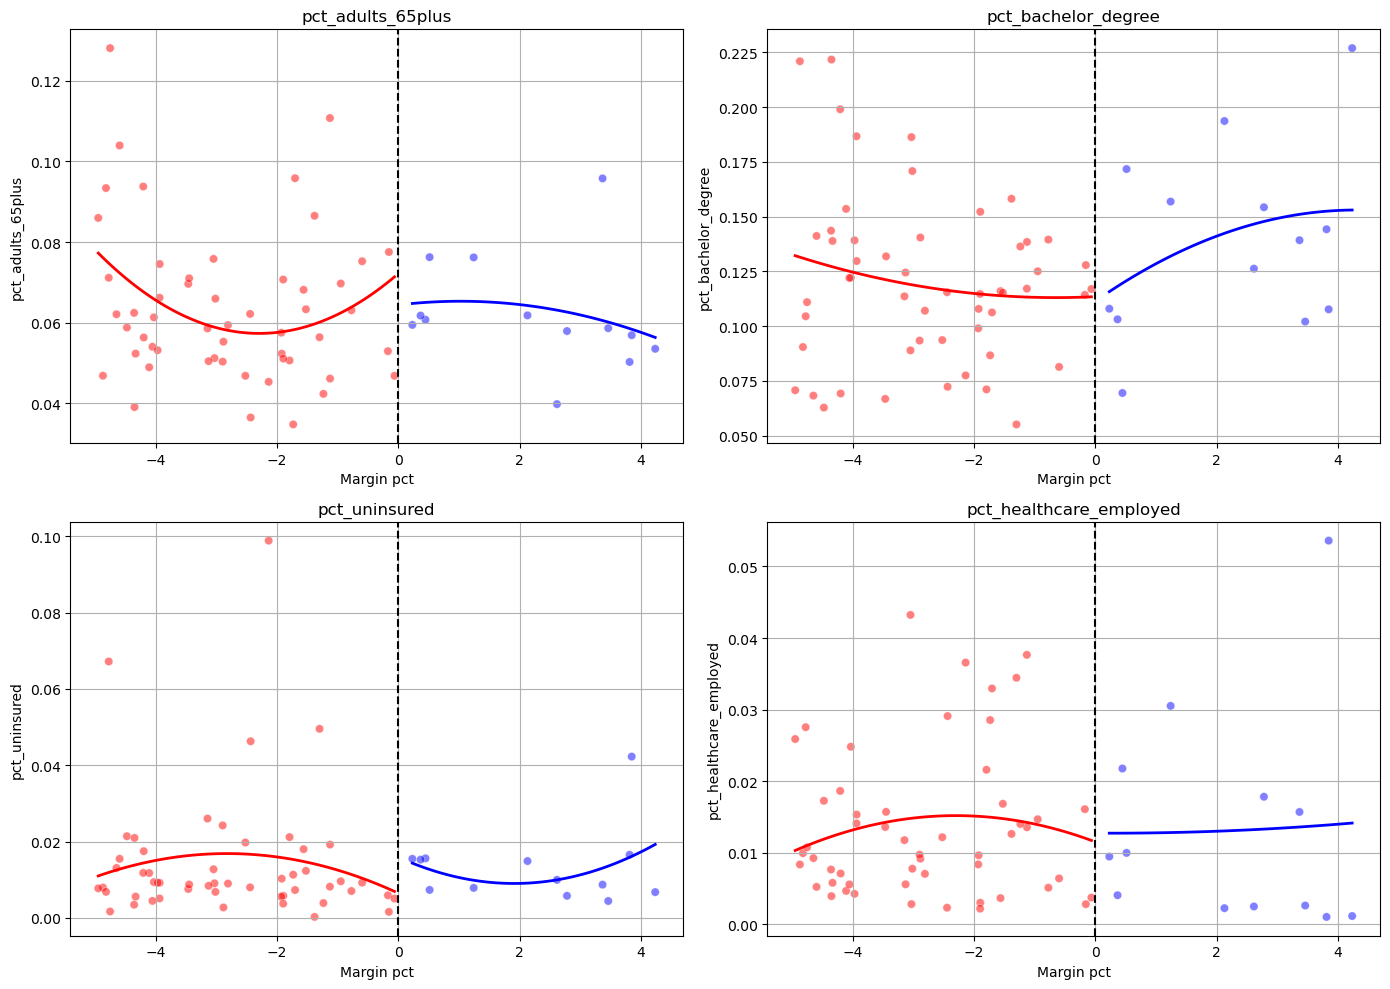

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

variables = ['pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed']

# Rango más amplio para ver la trayectoria
df_rango = df_merged[df_merged['margin_pct'].between(-5, 5)].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    # Scatterplot con color según dem_won
    sns.scatterplot(x='margin_pct', y=var, hue='dem_won', data=df_rango, alpha=0.5, ax=ax, palette=['red', 'blue'], legend=False)

    # Ajuste polinomial (grado 2) por separado para dem_won=0 y dem_won=1
    for group, color in zip([0,1], ['red', 'blue']):
        df_sub = df_rango[df_rango['dem_won'] == group]
        X = df_sub['margin_pct']
        y = df_sub[var]

        # Agregar constante y polinomio grado 2
        X_poly = np.column_stack((X, X**2))
        X_poly = sm.add_constant(X_poly)
        
        model = sm.OLS(y, X_poly, missing='drop').fit()
        x_pred = np.linspace(X.min(), X.max(), 100)
        X_pred_poly = np.column_stack((x_pred, x_pred**2))
        X_pred_poly = sm.add_constant(X_pred_poly)
        y_pred = model.predict(X_pred_poly)
        
        ax.plot(x_pred, y_pred, color=color, lw=2)

    ax.axvline(0, color='black', linestyle='--')
    ax.set_title(var)
    ax.set_xlabel('Margin pct')
    ax.set_ylabel(var)
    ax.grid(True)

plt.tight_layout()
plt.show()



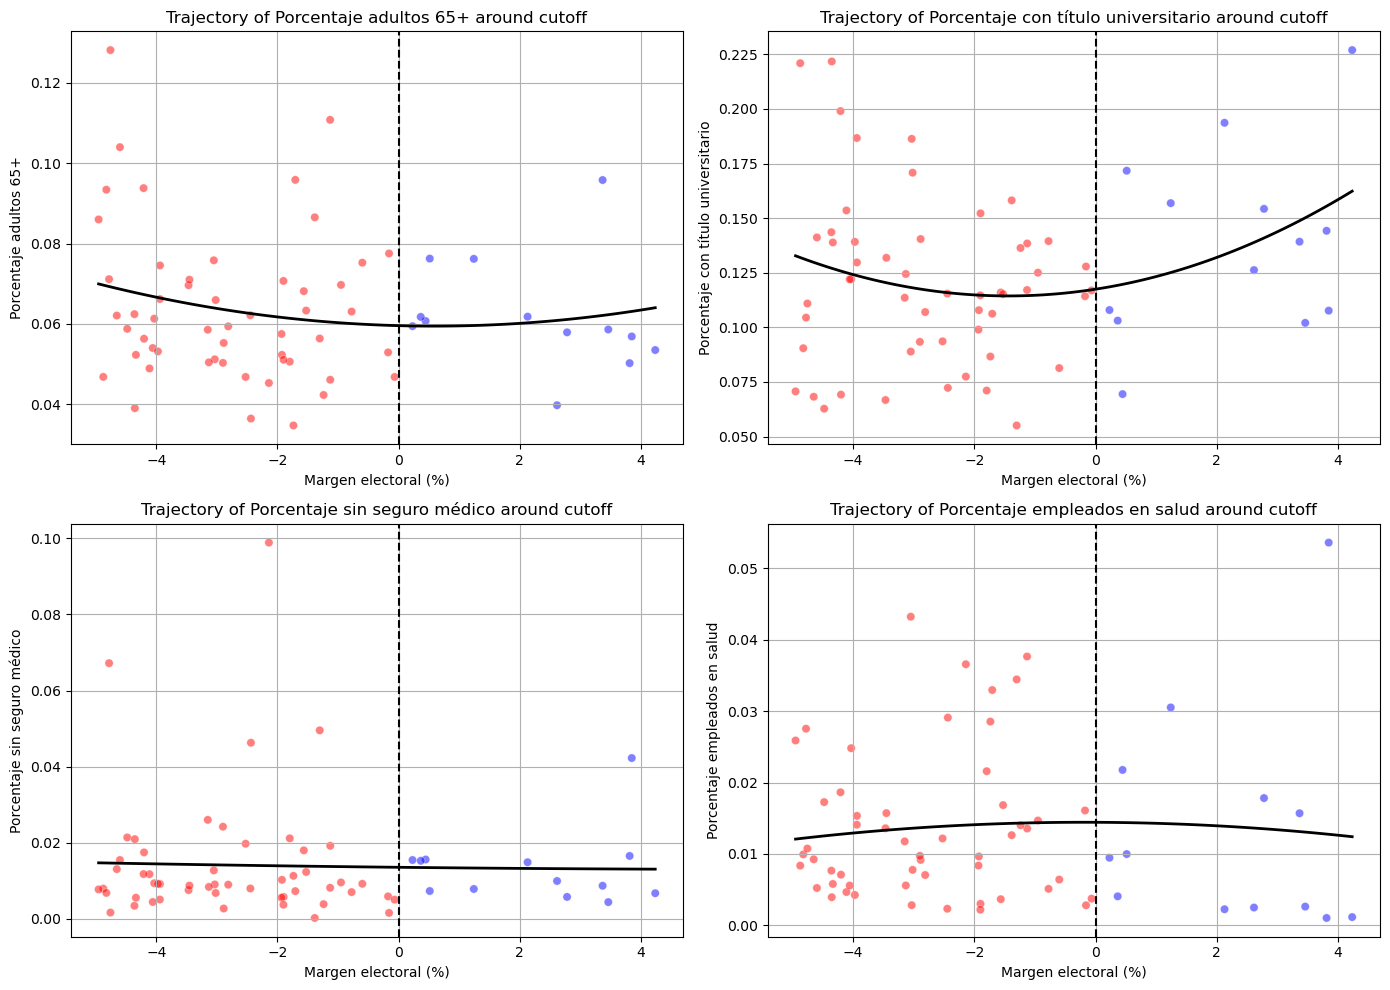

In [151]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

variables = ['pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed']

# Nombres completos para etiquetas y títulos
nombres_completos = {
    'pct_adults_65plus': 'Porcentaje adultos 65+',
    'pct_bachelor_degree': 'Porcentaje con título universitario',
    'pct_uninsured': 'Porcentaje sin seguro médico',
    'pct_healthcare_employed': 'Porcentaje empleados en salud'
}

# Rango para mostrar la trayectoria
df_rango = df_merged[df_merged['margin_pct'].between(-5, 5)].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    # Scatterplot con color según dem_won
    sns.scatterplot(
        x='margin_pct', y=var, hue='dem_won', data=df_rango,
        alpha=0.5, ax=ax, palette=['red', 'blue'], legend=False
    )

    # Ajuste polinomial grado 2 para todos los datos juntos
    X = df_rango['margin_pct']
    y = df_rango[var]

    X_poly = np.column_stack((X, X**2))
    X_poly = sm.add_constant(X_poly)
    
    model = sm.OLS(y, X_poly, missing='drop').fit()
    
    x_pred = np.linspace(X.min(), X.max(), 100)
    X_pred_poly = np.column_stack((x_pred, x_pred**2))
    X_pred_poly = sm.add_constant(X_pred_poly)
    
    y_pred = model.predict(X_pred_poly)
    
    ax.plot(x_pred, y_pred, color='black', lw=2, label='Polinomio grado 2')

    # Línea vertical en el punto de corte
    ax.axvline(0, color='black', linestyle='--')

    # Etiquetas y título
    ax.set_xlabel('Margen electoral (%)')
    ax.set_ylabel(nombres_completos.get(var, var))
    ax.set_title(f'Continuidad local de resultados potenciales para {nombres_completos.get(var, var)}')
    ax.grid(True)

plt.tight_layout()
plt.show()


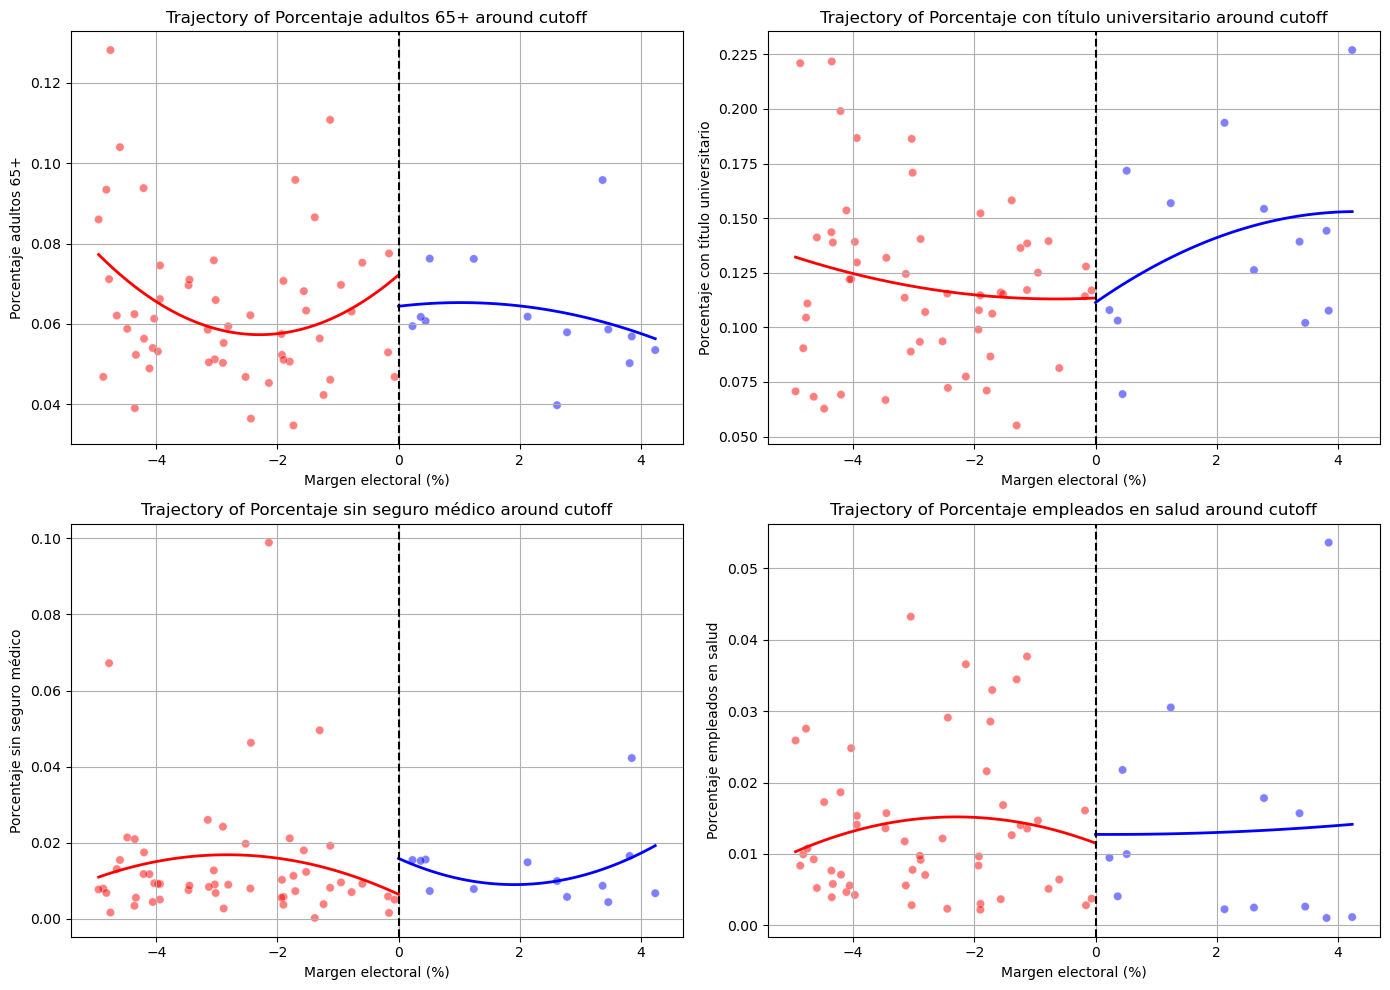

In [152]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

variables = ['pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed']

nombres_completos = {
    'pct_adults_65plus': 'Porcentaje adultos 65+',
    'pct_bachelor_degree': 'Porcentaje con título universitario',
    'pct_uninsured': 'Porcentaje sin seguro médico',
    'pct_healthcare_employed': 'Porcentaje empleados en salud'
}

df_rango = df_merged[df_merged['margin_pct'].between(-5, 5)].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    # Scatterplot coloreado por dem_won
    sns.scatterplot(
        x='margin_pct', y=var, hue='dem_won', data=df_rango,
        alpha=0.5, ax=ax, palette=['red', 'blue'], legend=False
    )
    
    # Ajuste polinomial lado izquierdo (margin_pct < 0)
    df_left = df_rango[df_rango['margin_pct'] < 0]
    X_left = df_left['margin_pct']
    y_left = df_left[var]
    X_poly_left = np.column_stack((X_left, X_left**2))
    X_poly_left = sm.add_constant(X_poly_left)
    model_left = sm.OLS(y_left, X_poly_left, missing='drop').fit()
    
    x_pred_left = np.linspace(X_left.min(), 0, 100)
    X_pred_poly_left = np.column_stack((x_pred_left, x_pred_left**2))
    X_pred_poly_left = sm.add_constant(X_pred_poly_left)
    y_pred_left = model_left.predict(X_pred_poly_left)
    ax.plot(x_pred_left, y_pred_left, color='red', lw=2, label='Polinomio izquierdo')

    # Ajuste polinomial lado derecho (margin_pct >= 0)
    df_right = df_rango[df_rango['margin_pct'] >= 0]
    X_right = df_right['margin_pct']
    y_right = df_right[var]
    X_poly_right = np.column_stack((X_right, X_right**2))
    X_poly_right = sm.add_constant(X_poly_right)
    model_right = sm.OLS(y_right, X_poly_right, missing='drop').fit()

    x_pred_right = np.linspace(0, X_right.max(), 100)
    X_pred_poly_right = np.column_stack((x_pred_right, x_pred_right**2))
    X_pred_poly_right = sm.add_constant(X_pred_poly_right)
    y_pred_right = model_right.predict(X_pred_poly_right)
    ax.plot(x_pred_right, y_pred_right, color='blue', lw=2, label='Polinomio derecho')

    # Línea vertical en el corte
    ax.axvline(0, color='black', linestyle='--')

    # Etiquetas y título
    ax.set_xlabel('Margen electoral (%)')
    ax.set_ylabel(nombres_completos.get(var, var))
    ax.set_title(f'Continuidad local de resultados potenciales para {nombres_completos.get(var, var)}')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [150]:
import statsmodels.formula.api as smf

# Lista de covariables que quieres testear
covariables = ['pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed']

# Filtrar datos cerca del punto de corte (por ejemplo margen electoral entre -5% y 5%)
df_rango = df_merged[df_merged['margin_pct'].between(-5, 5)].copy()

print("Test de continuidad local para covariables:\n")
for var in covariables:
    formula = f"{var} ~ dem_won"
    model = smf.ols(formula, data=df_rango).fit(cov_type='HC1')  # errores robustos
    pval = model.pvalues.get('dem_won', 1.0)
    coef = model.params.get('dem_won', 0)
    
    print(f"Variable: {var}")
    print(f"  Coeficiente de dem_won: {coef:.4f}")
    print(f"  Valor p: {pval:.4f}")
    if pval < 0.05:
        print("  --> Diferencia significativa. Posible discontinuidad local.\n")
    else:
        print("  --> No hay evidencia de discontinuidad local.\n")


Test de continuidad local para covariables:

Variable: pct_adults_65plus
  Coeficiente de dem_won: -0.0016
  Valor p: 0.7281
  --> No hay evidencia de discontinuidad local.

Variable: pct_bachelor_degree
  Coeficiente de dem_won: 0.0188
  Valor p: 0.1406
  --> No hay evidencia de discontinuidad local.

Variable: pct_uninsured
  Coeficiente de dem_won: -0.0011
  Valor p: 0.7634
  --> No hay evidencia de discontinuidad local.

Variable: pct_healthcare_employed
  Coeficiente de dem_won: -0.0003
  Valor p: 0.9399
  --> No hay evidencia de discontinuidad local.



# Nuevas variables del censo

In [8]:
import requests
import pandas as pd

# Tu API key
API_KEY = '29caaead12373544ff9fb7db17cb01532b2e2468'


# Año y dataset: American Community Survey 5-year estimates
year = '2021'
dataset = 'acs/acs5'

variables = {
    'B01003_001E': 'total_population',
    'B19013_001E': 'median_income',
    'B17001_002E': 'population_below_poverty',
    'B01001_020E': 'males_65_66',    
    'B01001_021E': 'males_67_69',
    'B01001_044E': 'females_65_66',
    'B01001_045E': 'females_67_69',
    'B15003_022E': 'bachelor_degree',
    'B27010_017E': 'uninsured_total', 
    'C24050_002E': 'healthcare_employed',
    'B02001_002E': 'white',
    'B02001_003E': 'black',
    'B02001_005E': 'asian',
    'B03003_003E': 'hispanic'
}

var_string = ",".join(variables.keys())

 
url = f"https://api.census.gov/data/{year}/{dataset}?get=NAME,{var_string}&for=county:*&in=state:*&key={API_KEY}"

 
response = requests.get(url)

 
data = response.json()
columns = data[0]
rows = data[1:]
df_census = pd.DataFrame(rows, columns=columns)

 
print(df_census.head())


                      NAME B01003_001E B19013_001E B17001_002E B01001_020E  \
0  Autauga County, Alabama       58239       62660        7847         539   
1  Baldwin County, Alabama      227131       64346       20598        3257   
2  Barbour County, Alabama       25259       36422        5890         297   
3     Bibb County, Alabama       22412       54277        3558         265   
4   Blount County, Alabama       58884       52830        7720         589   

  B01001_021E B01001_044E B01001_045E B15003_022E B27010_017E C24050_002E  \
0         697         444         947        6507         300         200   
1        3777        3082        4624       33379        2984        1827   
2         423         199         612        1212         154         469   
3         363         173         457        1276          94         299   
4        1100         600        1091        3783         484         443   

  B02001_002E B02001_003E B02001_005E B03003_003E state county  
0  

In [9]:

# Renombrar columnas
df_census = df_census.rename(columns=variables)
# Convertir columnas numéricas
for col in variables.values():
    df_census[col] = pd.to_numeric(df_census[col], errors='coerce')




In [10]:
df_census

NAME  total_population  median_income  \
0              Autauga County, Alabama             58239          62660   
1              Baldwin County, Alabama            227131          64346   
2              Barbour County, Alabama             25259          36422   
3                 Bibb County, Alabama             22412          54277   
4               Blount County, Alabama             58884          52830   
...                                ...               ...            ...   
3216  Vega Baja Municipio, Puerto Rico             54544          21507   
3217    Vieques Municipio, Puerto Rico              8317          14942   
3218   Villalba Municipio, Puerto Rico             22341          20722   
3219    Yabucoa Municipio, Puerto Rico             31047          17267   
3220      Yauco Municipio, Puerto Rico             34704          16444   

      population_below_poverty  males_65_66  males_67_69  females_65_66  \
0                         7847          539          697            444   
1                        20598         3257         3777           3082   
2                         5890          297          423            199   
3                         3558          265          363            173   
4                         7720          589         1100            600   
...                        ...          ...          ...            ...   
3216                     23520          371          831            689   
3217                      4425          257          159            101   
3218                      9881          177          356            366   
3219                     16335          346          630            328   
3220                     16048          436          766            430   

      females_67_69  bachelor_degree  uninsured_total  healthcare_employed  \
0               947             6507              300                  200   
1              4624            33379             2984                 1827   
2               612             1212              154                  469   
3               457             1276               94                  299   
4              1091             3783              484                  443   
...             ...              ...              ...                  ...   
3216            960             6627              987                  136   
3217            157              424                0                   15   
3218            353             2658               77                  231   
3219            846             3353              114                   56   
3220            739             5090              164                  194   

       white  black  asian  hispanic state county  
0      43755  11470    647      1775    01    001  
1     192034  19895   2175     10634    01    003  
2      11495  11985    106      1176    01    005  
3      17020   5003     46       634    01    007  
4      54439    760    216      5612    01    009  
...      ...    ...    ...       ...   ...    ...  
3216   30690   2409      9     53313    72    145  
3217    2592    629     14      7662    72    147  
3218   10502   1784      0     22259    72    149  
3219    3190  16119     11     31009    72    151  
3220   24533   1282      0     34341    72    153  

[3221 rows x 17 columns]

In [11]:
df_census['white_pct'] = pd.to_numeric(df_census['white'], errors='coerce')*100 / pd.to_numeric(df_census['total_population'], errors='coerce')
df_census['black_pct'] = pd.to_numeric(df_census['black'], errors='coerce')*100/ pd.to_numeric(df_census['total_population'], errors='coerce')
df_census['asian_pct'] = pd.to_numeric(df_census['asian'], errors='coerce')*100 / pd.to_numeric(df_census['total_population'], errors='coerce')
df_census['hispanic_pct'] = pd.to_numeric(df_census['hispanic'], errors='coerce')*100 / pd.to_numeric(df_census['total_population'], errors='coerce')
# Crear columna fips (2 dígitos state + 3 dígitos county)
df_census['fips'] = df_census['state'].str.zfill(2) + df_census['county'].str.zfill(3)

# Calcular adultos mayores 65+
df_census['adults_65plus'] = df_census['males_65_66'] + df_census['males_67_69'] + df_census['females_65_66'] + df_census['females_67_69']
df_census['pct_adults_65plus'] = df_census['adults_65plus']* 100 / df_census['total_population']

# Porcentaje con educación universitaria
df_census['pct_bachelor_degree'] = df_census['bachelor_degree']*100 / df_census['total_population']

# Porcentaje sin seguro médico
df_census['pct_uninsured'] = df_census['uninsured_total']*100/ df_census['total_population']

df_census['pct_healthcare_employed'] = df_census['healthcare_employed']*100 / df_census['total_population']

In [12]:
df_census['fips'] = df_census['state'].astype(str).str.zfill(2) + df_census['county'].astype(str).str.zfill(3)
df_census=df_census[['fips', 'pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed', 'white_pct', 'black_pct', 'asian_pct', 'hispanic_pct']]

In [13]:
df_merged = pd.merge(df_filtrado, df_census, on='fips', how='inner')
df_merged

dem_won2016   fips  margin_pct2016  geoid t_county_name  total_votes  \
0               1  12001       22.519499  12001       Alachua       142604   
1               0  12003      -64.761754  12003         Baker        14059   
2               1  12011       35.053723  12011       Broward       957672   
3               0  12013      -56.222186  12013       Calhoun         6526   
4               1  12031       -1.500697  12031         Duval       492820   
...           ...    ...             ...    ...           ...          ...   
2122            0  56033      -51.737506  56033      Sheridan        16428   
2123            0  56035      -64.347219  56035      Sublette         4970   
2124            0  56041      -61.492611  56041         Uinta         9402   
2125            0  56043      -64.037685  56043      Washakie         4012   
2126            0  56045      -78.104379  56045        Weston         3542   

     t_state_name  votes_gop  votes_dem  dem_won  margin_votes  margin_pct  \
0         Florida      50972      89704        1       3873200   27.160528   
1         Florida      11911       2037        0       -987400  -70.232591   
2         Florida     333409     618752        1      28534300   29.795483   
3         Florida       5274       1209        0       -406500  -62.289304   
4         Florida     233762     252556        1       1879400    3.813563   
...           ...        ...        ...      ...           ...         ...   
2122      Wyoming      11843       4043        0       -780000  -47.479912   
2123      Wyoming       3957        882        0       -307500  -61.871227   
2124      Wyoming       7496       1591        0       -590500  -62.805786   
2125      Wyoming       3245        651        0       -259400  -64.656032   
2126      Wyoming       3107        360        0       -274700  -77.555054   

      pct_adults_65plus  pct_bachelor_degree  pct_uninsured  \
0              5.143914            14.241539       0.870475   
1              5.285148             6.224333       2.671142   
2              5.270991            15.067269       2.025586   
3              5.655342             5.460579       2.813244   
4              5.023023            14.421255       1.654473   
...                 ...                  ...            ...   
2122           6.692198            12.683370       1.389069   
2123           5.956965            14.473386       1.913930   
2124           5.605928             7.945793       1.969387   
2125           7.839856            12.036560       0.669413   
2126           6.573792             9.838920       3.381222   

      pct_healthcare_employed  white_pct  black_pct  asian_pct  hispanic_pct  
0                    0.425099  65.653526  19.853279   5.962248     10.497482  
1                    0.182123  79.098668  12.595079   0.328536      2.899689  
2                    0.121062  52.493059  28.543419   3.618049     30.890010  
3                    1.918777  77.703239  12.096949   0.533795      6.044868  
4                    0.102324  56.096966  29.436008   4.734461     10.633442  
...                       ...        ...        ...        ...           ...  
2122                 3.998442  93.554459   0.467350   1.002856      4.550175  
2123                13.114383  96.013590   0.011325   0.000000      7.259343  
2124                 4.309252  92.127328   0.253485   0.180365      9.656820  
2125                 4.325438  85.671988   0.012873   0.399073     14.379506  
2126                10.912785  89.304890   0.362792   0.754607      1.857495  

[2127 rows x 20 columns]

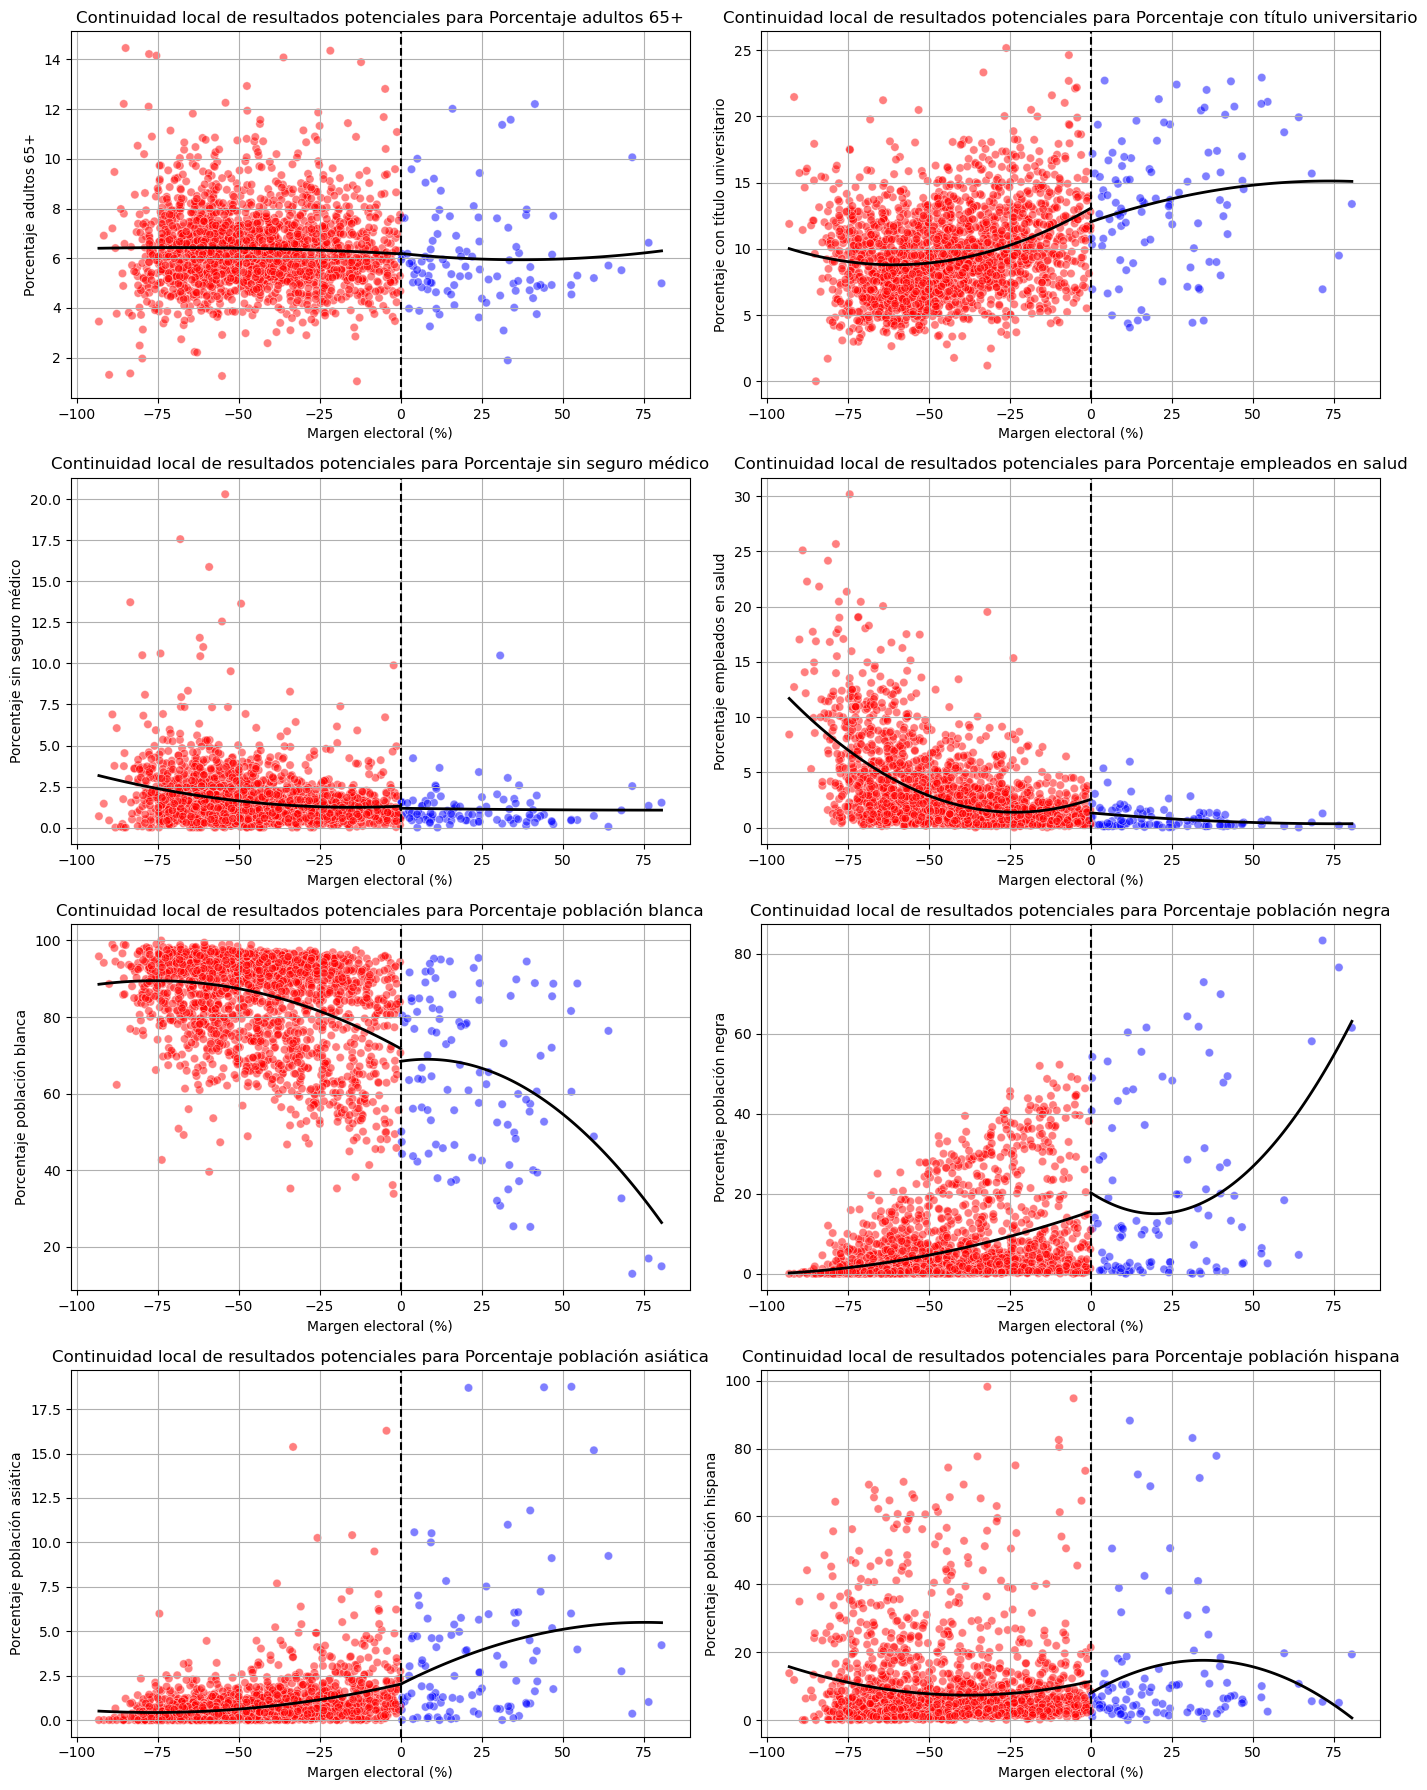

In [14]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
variables = [
    'pct_adults_65plus', 'pct_bachelor_degree', 'pct_uninsured', 'pct_healthcare_employed',
    'white_pct', 'black_pct', 'asian_pct', 'hispanic_pct'
]

nombres_completos = {
    'pct_adults_65plus': 'Porcentaje adultos 65+',
    'pct_bachelor_degree': 'Porcentaje con título universitario',
    'pct_uninsured': 'Porcentaje sin seguro médico',
    'pct_healthcare_employed': 'Porcentaje empleados en salud',
    'white_pct': "Porcentaje población blanca",
    'black_pct': "Porcentaje población negra",
    'asian_pct': "Porcentaje población asiática",
    'hispanic_pct': "Porcentaje población hispana"
}

df_rango = df_merged[df_merged['margin_pct'].between(-500, 500)].copy()

fig, axes = plt.subplots(4, 2, figsize=(14, 18))  # 4 filas, 2 columnas
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    sns.scatterplot(
        x='margin_pct', y=var, hue='dem_won', data=df_rango,
        alpha=0.5, ax=ax, palette=['red', 'blue'], legend=False
    )
    
    df_left = df_rango[df_rango['margin_pct'] < 0]
    X_left = df_left['margin_pct']
    y_left = df_left[var]
    X_poly_left = np.column_stack((X_left, X_left**2))
    X_poly_left = sm.add_constant(X_poly_left)
    model_left = sm.OLS(y_left, X_poly_left, missing='drop').fit()
    
    x_pred_left = np.linspace(X_left.min(), 0, 100)
    X_pred_poly_left = np.column_stack((x_pred_left, x_pred_left**2))
    X_pred_poly_left = sm.add_constant(X_pred_poly_left)
    y_pred_left = model_left.predict(X_pred_poly_left)
    ax.plot(x_pred_left, y_pred_left, color='black', lw=2, label='Polinomio izquierdo')

    df_right = df_rango[df_rango['margin_pct'] >= 0]
    X_right = df_right['margin_pct']
    y_right = df_right[var]
    X_poly_right = np.column_stack((X_right, X_right**2))
    X_poly_right = sm.add_constant(X_poly_right)
    model_right = sm.OLS(y_right, X_poly_right, missing='drop').fit()

    x_pred_right = np.linspace(0, X_right.max(), 100)
    X_pred_poly_right = np.column_stack((x_pred_right, x_pred_right**2))
    X_pred_poly_right = sm.add_constant(X_pred_poly_right)
    y_pred_right = model_right.predict(X_pred_poly_right)
    ax.plot(x_pred_right, y_pred_right, color='black', lw=2, label='Polinomio derecho')

    ax.axvline(0, color='black', linestyle='--')
    ax.set_xlabel('Margen electoral (%)')
    ax.set_ylabel(nombres_completos.get(var, var))
    ax.set_title(f'Continuidad local de resultados potenciales para {nombres_completos.get(var, var)}')
    ax.grid(True)

plt.tight_layout()
plt.show()


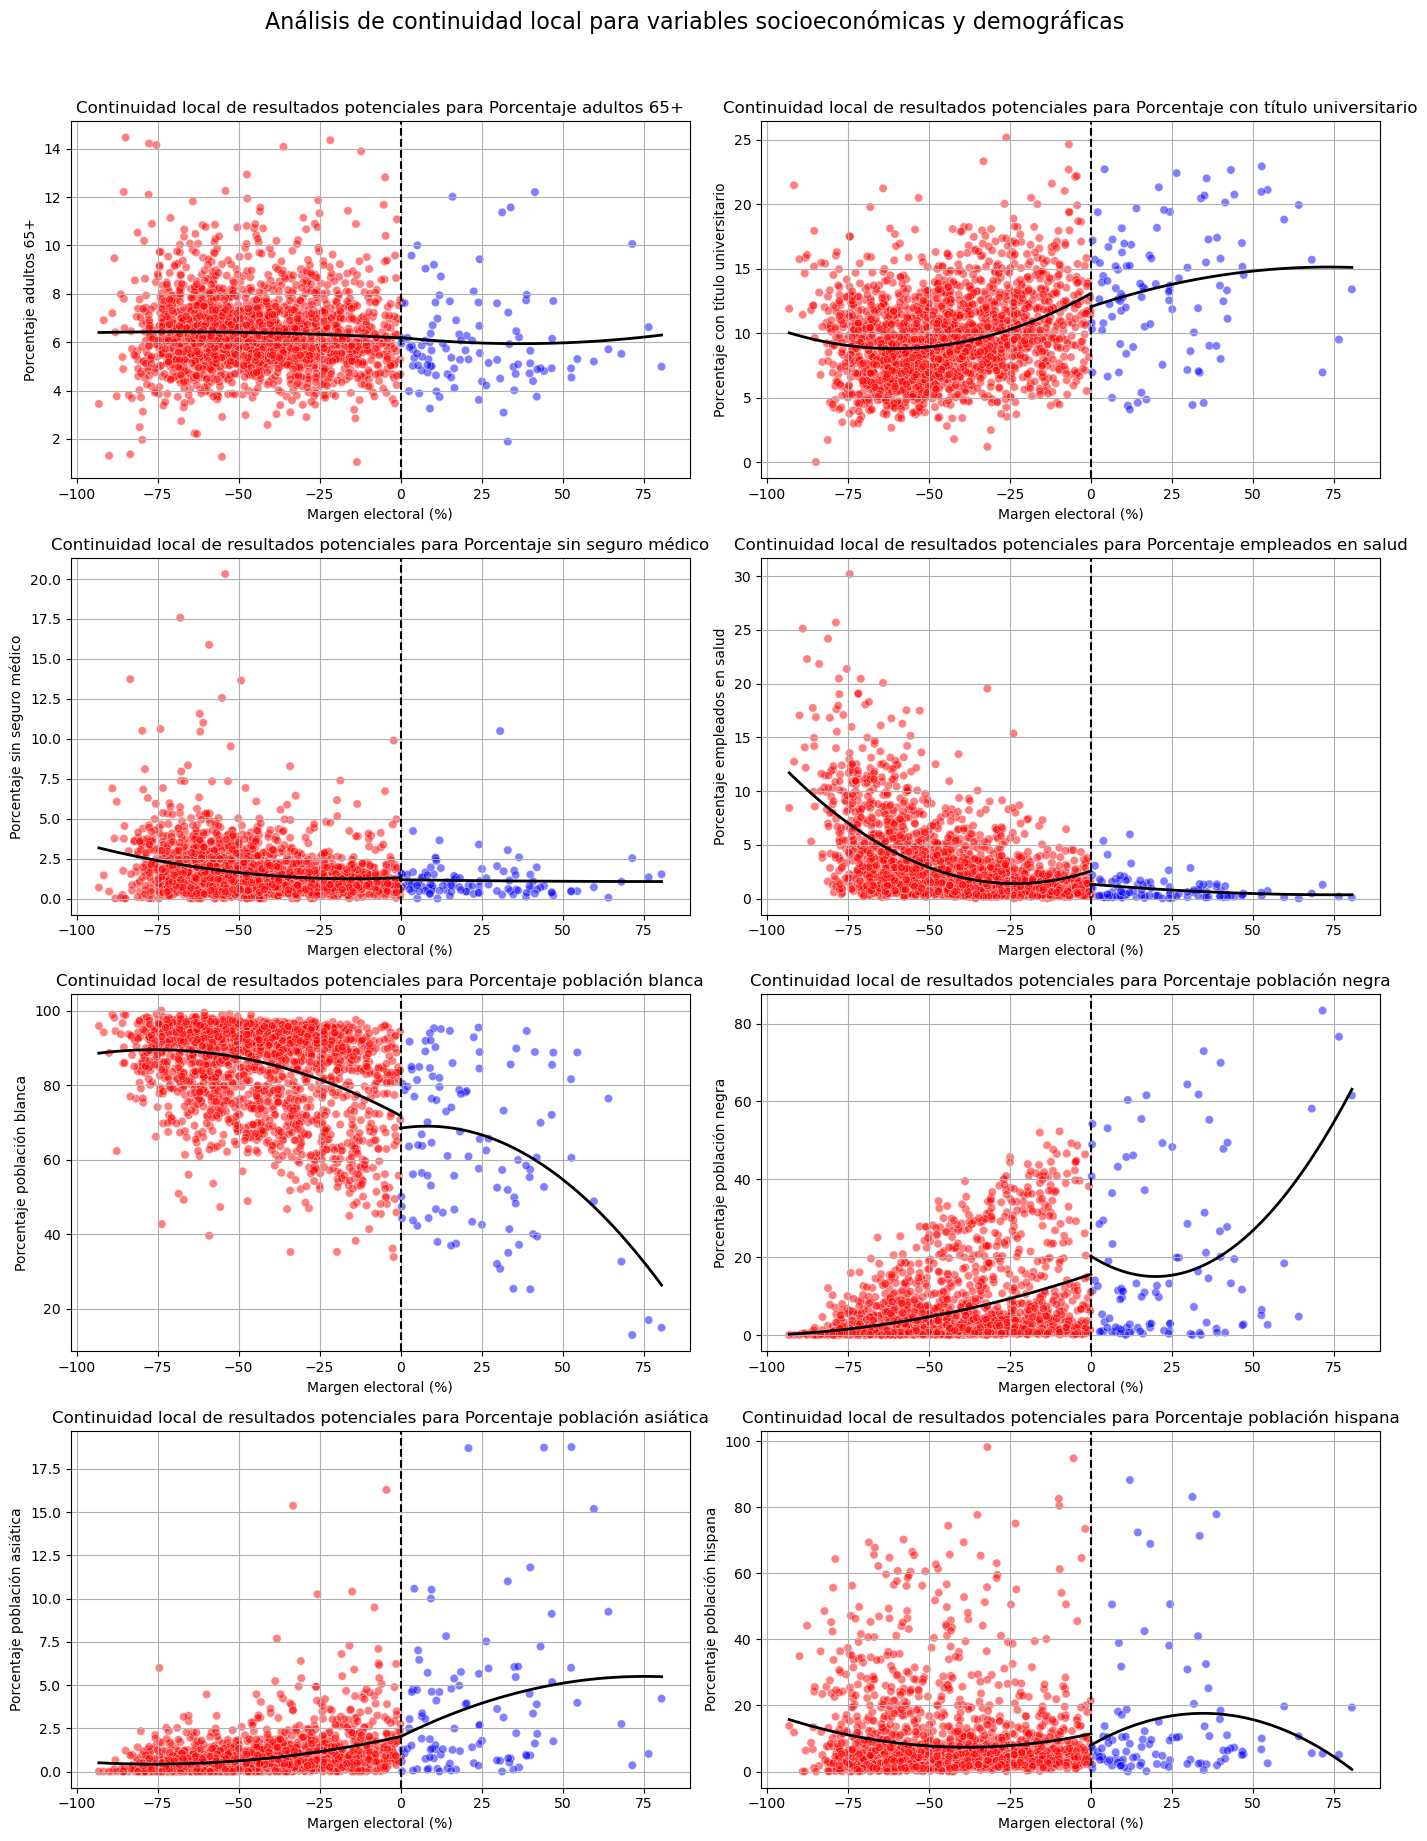

In [16]:
df_rango = df_merged[df_merged['margin_pct'].between(-500, 500)].copy()
fig, axes = plt.subplots(4, 2, figsize=(14, 18))  # 4 filas, 2 columnas
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    sns.scatterplot(
        x='margin_pct', y=var, hue='dem_won', data=df_rango,
        alpha=0.5, ax=ax, palette=['red', 'blue'], legend=False
    )
    
    df_left = df_rango[df_rango['margin_pct'] < 0]
    X_left = df_left['margin_pct']
    y_left = df_left[var]
    X_poly_left = np.column_stack((X_left, X_left**2))
    X_poly_left = sm.add_constant(X_poly_left)
    model_left = sm.OLS(y_left, X_poly_left, missing='drop').fit()
    
    x_pred_left = np.linspace(X_left.min(), 0, 100)
    X_pred_poly_left = np.column_stack((x_pred_left, x_pred_left**2))
    X_pred_poly_left = sm.add_constant(X_pred_poly_left)
    y_pred_left = model_left.predict(X_pred_poly_left)
    ax.plot(x_pred_left, y_pred_left, color='black', lw=2, label='Polinomio izquierdo')

    df_right = df_rango[df_rango['margin_pct'] >= 0]
    X_right = df_right['margin_pct']
    y_right = df_right[var]
    X_poly_right = np.column_stack((X_right, X_right**2))
    X_poly_right = sm.add_constant(X_poly_right)
    model_right = sm.OLS(y_right, X_poly_right, missing='drop').fit()

    x_pred_right = np.linspace(0, X_right.max(), 100)
    X_pred_poly_right = np.column_stack((x_pred_right, x_pred_right**2))
    X_pred_poly_right = sm.add_constant(X_pred_poly_right)
    y_pred_right = model_right.predict(X_pred_poly_right)
    ax.plot(x_pred_right, y_pred_right, color='black', lw=2, label='Polinomio derecho')

    ax.axvline(0, color='black', linestyle='--')
    ax.set_xlabel('Margen electoral (%)')
    ax.set_ylabel(nombres_completos.get(var, var))
    ax.set_title(f'Continuidad local de resultados potenciales para {nombres_completos.get(var, var)}')
    ax.grid(True)

fig.suptitle('Análisis de continuidad local para variables socioeconómicas y demográficas', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [194]:
import numpy as np
import pandas as pd
from scipy import stats

windows = [5, 2.5, 1]

for w in windows:
    print(f"\n--- Test t para ventana ganar (+) o perder marginalmente (-) con ±{w} p.p ---")
    df_window = df_merged[df_merged['margin_pct'].between(-w, w)]
    
    count_0 = (df_window['dem_won'] == 0).sum()
    count_1 = (df_window['dem_won'] == 1).sum()
    total = len(df_window)
    print(f"Observaciones - dem_won=0: {count_0}, dem_won=1: {count_1}, total: {total}")
    
    for var in variables:
        group0 = df_window[df_window['dem_won'] == 0][var].dropna()
        group1 = df_window[df_window['dem_won'] == 1][var].dropna()
        
        t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
        
        print(f"{var}: t = {t_stat:.3f}, p = {p_val:.3f}")



--- Test t para ventana ganar (+) o perder marginalmente (-) con ±5 p.p ---
Observaciones - dem_won=0: 53, dem_won=1: 13, total: 66
pct_adults_65plus: t = 0.343, p = 0.735
pct_bachelor_degree: t = -1.445, p = 0.166
pct_uninsured: t = 0.298, p = 0.768
pct_healthcare_employed: t = 0.074, p = 0.942
white_pct: t = 1.291, p = 0.213
black_pct: t = -1.269, p = 0.222
asian_pct: t = -0.708, p = 0.489
hispanic_pct: t = 1.900, p = 0.062

--- Test t para ventana ganar (+) o perder marginalmente (-) con ±2.5 p.p ---
Observaciones - dem_won=0: 23, dem_won=1: 6, total: 29
pct_adults_65plus: t = -0.882, p = 0.388
pct_bachelor_degree: t = -1.147, p = 0.296
pct_uninsured: t = 0.673, p = 0.507
pct_healthcare_employed: t = 0.480, p = 0.643
white_pct: t = 1.141, p = 0.287
black_pct: t = -2.387, p = 0.054
asian_pct: t = 2.904, p = 0.008
hispanic_pct: t = 1.722, p = 0.097

--- Test t para ventana ganar (+) o perder marginalmente (-) con ±1 p.p ---
Observaciones - dem_won=0: 6, dem_won=1: 4, total: 10
pct_ad

In [198]:
df_merged

dem_won2016   fips  margin_pct2016  geoid t_county_name  total_votes  \
0               1  12001       22.519499  12001       Alachua       142604   
1               0  12003      -64.761754  12003         Baker        14059   
2               1  12011       35.053723  12011       Broward       957672   
3               0  12013      -56.222186  12013       Calhoun         6526   
4               1  12031       -1.500697  12031         Duval       492820   
...           ...    ...             ...    ...           ...          ...   
2122            0  56033      -51.737506  56033      Sheridan        16428   
2123            0  56035      -64.347219  56035      Sublette         4970   
2124            0  56041      -61.492611  56041         Uinta         9402   
2125            0  56043      -64.037685  56043      Washakie         4012   
2126            0  56045      -78.104379  56045        Weston         3542   

     t_state_name  votes_gop  votes_dem  dem_won  margin_votes  margin_pct  \
0         Florida      50972      89704        1       3873200   27.160528   
1         Florida      11911       2037        0       -987400  -70.232591   
2         Florida     333409     618752        1      28534300   29.795483   
3         Florida       5274       1209        0       -406500  -62.289304   
4         Florida     233762     252556        1       1879400    3.813563   
...           ...        ...        ...      ...           ...         ...   
2122      Wyoming      11843       4043        0       -780000  -47.479912   
2123      Wyoming       3957        882        0       -307500  -61.871227   
2124      Wyoming       7496       1591        0       -590500  -62.805786   
2125      Wyoming       3245        651        0       -259400  -64.656032   
2126      Wyoming       3107        360        0       -274700  -77.555054   

      pct_adults_65plus  pct_bachelor_degree  pct_uninsured  \
0              0.051439             0.142415       0.008705   
1              0.052851             0.062243       0.026711   
2              0.052710             0.150673       0.020256   
3              0.056553             0.054606       0.028132   
4              0.050230             0.144213       0.016545   
...                 ...                  ...            ...   
2122           0.066922             0.126834       0.013891   
2123           0.059570             0.144734       0.019139   
2124           0.056059             0.079458       0.019694   
2125           0.078399             0.120366       0.006694   
2126           0.065738             0.098389       0.033812   

      pct_healthcare_employed  white_pct  black_pct  asian_pct  hispanic_pct  
0                    0.004251   0.656535   0.198533   0.059622      0.104975  
1                    0.001821   0.790987   0.125951   0.003285      0.028997  
2                    0.001211   0.524931   0.285434   0.036180      0.308900  
3                    0.019188   0.777032   0.120969   0.005338      0.060449  
4                    0.001023   0.560970   0.294360   0.047345      0.106334  
...                       ...        ...        ...        ...           ...  
2122                 0.039984   0.935545   0.004674   0.010029      0.045502  
2123                 0.131144   0.960136   0.000113   0.000000      0.072593  
2124                 0.043093   0.921273   0.002535   0.001804      0.096568  
2125                 0.043254   0.856720   0.000129   0.003991      0.143795  
2126                 0.109128   0.893049   0.003628   0.007546      0.018575  

[2127 rows x 20 columns]

In [199]:
df_stata = pd.merge(df_merged, df_unico_fips, on='fips', how='inner')
df_stata 

dem_won2016   fips  margin_pct2016  geoid t_county_name  total_votes  \
0               1  12001       22.519499  12001       Alachua       142604   
1               0  12003      -64.761754  12003         Baker        14059   
2               1  12011       35.053723  12011       Broward       957672   
3               0  12013      -56.222186  12013       Calhoun         6526   
4               1  12031       -1.500697  12031         Duval       492820   
...           ...    ...             ...    ...           ...          ...   
2122            0  56033      -51.737506  56033      Sheridan        16428   
2123            0  56035      -64.347219  56035      Sublette         4970   
2124            0  56041      -61.492611  56041         Uinta         9402   
2125            0  56043      -64.037685  56043      Washakie         4012   
2126            0  56045      -78.104379  56045        Weston         3542   

     t_state_name  votes_gop  votes_dem  dem_won  ...  \
0         Florida      50972      89704        1  ...   
1         Florida      11911       2037        0  ...   
2         Florida     333409     618752        1  ...   
3         Florida       5274       1209        0  ...   
4         Florida     233762     252556        1  ...   
...           ...        ...        ...      ...  ...   
2122      Wyoming      11843       4043        0  ...   
2123      Wyoming       3957        882        0  ...   
2124      Wyoming       7496       1591        0  ...   
2125      Wyoming       3245        651        0  ...   
2126      Wyoming       3107        360        0  ...   

      series_complete_18pluspop_pct_svi  series_complete_65pluspop_pct_svi  \
0                                     7                                  8   
1                                     9                                 11   
2                                    10                                 11   
3                                    13                                 15   
4                                    10                                 12   
...                                 ...                                ...   
2122                                  3                                  4   
2123                                  1                                  2   
2124                                  6                                  7   
2125                                  6                                  7   
2126                                  5                                  7   

      metro_status  series_complete_pop_pct_ur_equity  \
0            Metro                                  2   
1            Metro                                  1   
2            Metro                                  1   
3        Non-metro                                  5   
4            Metro                                  1   
...            ...                                ...   
2122     Non-metro                                  6   
2123     Non-metro                                  5   
2124     Non-metro                                  5   
2125     Non-metro                                  5   
2126     Non-metro                                  5   

      series_complete_12pluspop_pct_ur_equity  \
0                                           2   
1                                           1   
2                                           2   
3                                           5   
4                                           2   
...                                       ...   
2122                                        6   
2123                                        5   
2124                                        5   
2125                                        6   
2126                                        5   

      series_complete_18pluspop_pct_ur_equity  \
0                                           3   
1                                           1   
2                         

In [209]:
df_stata = pd.merge(df_merged, df_unico_fips, on='fips', how='inner')
df_stata

dem_won2016   fips  margin_pct2016  geoid t_county_name  total_votes  \
0               1  12001       22.519499  12001       Alachua       142604   
1               0  12003      -64.761754  12003         Baker        14059   
2               1  12011       35.053723  12011       Broward       957672   
3               0  12013      -56.222186  12013       Calhoun         6526   
4               1  12031       -1.500697  12031         Duval       492820   
...           ...    ...             ...    ...           ...          ...   
2122            0  56033      -51.737506  56033      Sheridan        16428   
2123            0  56035      -64.347219  56035      Sublette         4970   
2124            0  56041      -61.492611  56041         Uinta         9402   
2125            0  56043      -64.037685  56043      Washakie         4012   
2126            0  56045      -78.104379  56045        Weston         3542   

     t_state_name  votes_gop  votes_dem  dem_won  ...  \
0         Florida      50972      89704        1  ...   
1         Florida      11911       2037        0  ...   
2         Florida     333409     618752        1  ...   
3         Florida       5274       1209        0  ...   
4         Florida     233762     252556        1  ...   
...           ...        ...        ...      ...  ...   
2122      Wyoming      11843       4043        0  ...   
2123      Wyoming       3957        882        0  ...   
2124      Wyoming       7496       1591        0  ...   
2125      Wyoming       3245        651        0  ...   
2126      Wyoming       3107        360        0  ...   

      series_complete_18pluspop_pct_svi  series_complete_65pluspop_pct_svi  \
0                                     7                                  8   
1                                     9                                 11   
2                                    10                                 11   
3                                    13                                 15   
4                                    10                                 12   
...                                 ...                                ...   
2122                                  3                                  4   
2123                                  1                                  2   
2124                                  6                                  7   
2125                                  6                                  7   
2126                                  5                                  7   

      metro_status  series_complete_pop_pct_ur_equity  \
0            Metro                                  2   
1            Metro                                  1   
2            Metro                                  1   
3        Non-metro                                  5   
4            Metro                                  1   
...            ...                                ...   
2122     Non-metro                                  6   
2123     Non-metro                                  5   
2124     Non-metro                                  5   
2125     Non-metro                                  5   
2126     Non-metro                                  5   

      series_complete_12pluspop_pct_ur_equity  \
0                                           2   
1                                           1   
2                                           2   
3                                           5   
4                                           2   
...                                       ...   
2122                                        6   
2123                                        5   
2124                                        5   
2125                                        6   
2126                                        5   

      series_complete_18pluspop_pct_ur_equity  \
0                                           3   
1                                           1   
2                         

In [200]:
df_stata

dem_won2016   fips  margin_pct2016  geoid t_county_name  total_votes  \
0               1  12001       22.519499  12001       Alachua       142604   
1               0  12003      -64.761754  12003         Baker        14059   
2               1  12011       35.053723  12011       Broward       957672   
3               0  12013      -56.222186  12013       Calhoun         6526   
4               1  12031       -1.500697  12031         Duval       492820   
...           ...    ...             ...    ...           ...          ...   
2122            0  56033      -51.737506  56033      Sheridan        16428   
2123            0  56035      -64.347219  56035      Sublette         4970   
2124            0  56041      -61.492611  56041         Uinta         9402   
2125            0  56043      -64.037685  56043      Washakie         4012   
2126            0  56045      -78.104379  56045        Weston         3542   

     t_state_name  votes_gop  votes_dem  dem_won  ...  \
0         Florida      50972      89704        1  ...   
1         Florida      11911       2037        0  ...   
2         Florida     333409     618752        1  ...   
3         Florida       5274       1209        0  ...   
4         Florida     233762     252556        1  ...   
...           ...        ...        ...      ...  ...   
2122      Wyoming      11843       4043        0  ...   
2123      Wyoming       3957        882        0  ...   
2124      Wyoming       7496       1591        0  ...   
2125      Wyoming       3245        651        0  ...   
2126      Wyoming       3107        360        0  ...   

      series_complete_18pluspop_pct_svi  series_complete_65pluspop_pct_svi  \
0                                     7                                  8   
1                                     9                                 11   
2                                    10                                 11   
3                                    13                                 15   
4                                    10                                 12   
...                                 ...                                ...   
2122                                  3                                  4   
2123                                  1                                  2   
2124                                  6                                  7   
2125                                  6                                  7   
2126                                  5                                  7   

      metro_status  series_complete_pop_pct_ur_equity  \
0            Metro                                  2   
1            Metro                                  1   
2            Metro                                  1   
3        Non-metro                                  5   
4            Metro                                  1   
...            ...                                ...   
2122     Non-metro                                  6   
2123     Non-metro                                  5   
2124     Non-metro                                  5   
2125     Non-metro                                  5   
2126     Non-metro                                  5   

      series_complete_12pluspop_pct_ur_equity  \
0                                           2   
1                                           1   
2                                           2   
3                                           5   
4                                           2   
...                                       ...   
2122                                        6   
2123                                        5   
2124                                        5   
2125                                        6   
2126                                        5   

      series_complete_18pluspop_pct_ur_equity  \
0                                           3   
1                                           1   
2                         

In [201]:
df_stata.to_stata('baselimpiavac2023.dta', write_index=False)


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\io\stata.py:2491: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    administered_dose1_recip_12pluspop_pct   ->   administered_dose1_recip_12plusp
    administered_dose1_recip_18pluspop_pct   ->   administered_dose1_recip_18plusp
    administered_dose1_recip_65pluspop_pct   ->   administered_dose1_recip_65plusp
    series_complete_12pluspop_pct_svi   ->   series_complete_12pluspop_pct_sv
    series_complete_18pluspop_pct_svi   ->   series_complete_18pluspop_pct_sv
    series_complete_65pluspop_pct_svi   ->   series_complete_65pluspop_pct_sv
    series_complete_pop_pct_ur_equity   ->   series_complete_pop_pct_ur_equit
    series_complete_12pluspop_pct_ur_equity   ->   series_complete_12pluspop_pct_ur
    series_complete_18pluspop_pct_ur_equity   ->   series_complete_18pluspop_pct_ur
    series_complete_65pluspop_pct_ur_equity  

In [3]:
import pandas as pd

df_census = pd.read_stata('baselimpiavac2023.dta')


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rddensity

x = df_census['margin_pct'].values

plt.figure(figsize=(8,6))
sns.kdeplot(x, color='black', fill=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Densidad de la variable de focalización")
plt.xlabel("Margen de Victoria de los Democrátas")
plt.ylabel("Densidad")
plt.show()

result = rddensity.rddensity(x, c=0)

print(result.summary())

fig = result.plot()
fig.suptitle("Test de manipulación")
plt.xlabel("Margen de Victoria de los Democrátas")
plt.ylabel("Densidad de la variable de focalización")
plt.show()


In [4]:
pip install --upgrade numpy scipy pandas matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl (11.6 MB)
  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)
     ---------------------------------------- 11.2/11.2 MB 6.1 MB/s eta 0:00:00
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2



ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\HP\\AppData\\Roaming\\Python\\Python39\\site-packages\\~-learn\\.libs\\msvcp140.dll'
Check the permissions.

